### Project Chicago: Transform ResStock PACKAGE Results to 15 SFD prototypes (Elevate Energy)
Created on: 01/07/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [2]:
# local path to downloaded results
iteration = '03' # <----- options: 03, 03_sfd, 03_sfamh
iter_path = f'cookcnty_packages_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir, iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Results path: \n   {result_path}')


Results path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03


### Functions

In [3]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui_thermpersqft'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui_kwhpersqft'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui_kbtupersqft'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
    
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')

def load_upgrade(n, file_dir=result_path):
    """
    ARG:
        n (int, str): upgrade number
        file_dir (str): folder in which upgrade can be found, default to main result dir
    RETURN:
        df (dataframe) of upgrade n
    """
    df = pd.read_parquet(os.path.join(file_dir,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    return df
print('func loaded: "load_upgrade"')



func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"
func loaded: "load_upgrade"


### 1. BASELINE results

In [4]:
save_a_copy_in_csv = False # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)

if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)
    
# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
jobs_missing = set(range(1,100)) - set(res.job_id.unique())
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {16777-len(res)} buildings ({((16777-len(res))/16777*100):.2f}%)')

res

- 0 jobs missing: set()
- 0 buildings (0.00%)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft
0,1,58,2021-05-22 03:00:51,2021-05-22 03:02:16,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.909091,18.272727,18.471290,14.904212,4697.0,20.325657,885.0,1.148604,11.168538,152.941590
1,2,42,2021-05-22 04:35:27,2021-05-22 04:37:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.181818,18.545455,16.123814,9.113648,4793.0,16.834492,3301.0,0.458190,3.037824,56.173532
2,3,45,2021-05-22 04:25:25,2021-05-22 04:26:50,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.090909,17.909091,14.044363,11.014080,4742.0,17.919366,1690.0,0.679707,4.270654,82.526620
3,4,95,2021-05-22 05:01:11,2021-05-22 05:02:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,18.454545,10.888104,9.437645,4747.0,11.565472,2176.0,0.577049,4.668036,73.619101
4,5,55,2021-05-22 03:47:52,2021-05-22 03:49:13,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,13.454545,15.534798,29.826622,618.0,32.951464,1690.0,0.000000,11.628102,39.676699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,4,2021-05-22 01:53:40,2021-05-22 01:55:05,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.000000,15.181818,27.121830,18.715448,5176.0,30.142269,2176.0,0.769895,4.137007,91.087238
16773,16774,30,2021-05-22 05:37:07,2021-05-22 05:38:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.090909,16.090909,17.477228,12.475251,4743.0,21.115732,1220.0,1.701445,8.439143,198.899492
16774,16775,59,2021-05-22 04:47:18,2021-05-22 04:48:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.545455,17.181818,16.113838,7.591218,3591.0,16.801540,1690.0,1.358050,4.786423,152.104601
16775,16776,67,2021-05-22 06:17:04,2021-05-22 06:18:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.090909,18.636364,30.521647,13.540854,4982.0,32.179127,8194.0,0.444149,2.095277,51.553733


In [5]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [6]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_packages_03 - BASELINE result summary:

  * 16753 / 16777 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.669134
2            0.305199
3            0.025667
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.544858
WoodStud     0.455142
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.357548
1960-79      0.265147
1980-99      0.100937
2000-09      0.044589
2010s        0.006447
<1940        0.225333
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.828687
Heat Pump      0.006029
None           0.010923
Room AC        0.154360
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP    

### 1.2. Add additional metrics to Baseline

In [7]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories
0,1,58,2021-05-22 03:00:51,2021-05-22 03:02:16,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.471290,14.904212,4697.0,20.325657,885.0,1.148604,11.168538,152.941590,2: 1942-1978,1: <2 stories
1,2,42,2021-05-22 04:35:27,2021-05-22 04:37:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.123814,9.113648,4793.0,16.834492,3301.0,0.458190,3.037824,56.173532,3: post-1978,2: 2+ stories
2,3,45,2021-05-22 04:25:25,2021-05-22 04:26:50,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.044363,11.014080,4742.0,17.919366,1690.0,0.679707,4.270654,82.526620,3: post-1978,2: 2+ stories
3,4,95,2021-05-22 05:01:11,2021-05-22 05:02:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,10.888104,9.437645,4747.0,11.565472,2176.0,0.577049,4.668036,73.619101,2: 1942-1978,1: <2 stories
4,5,55,2021-05-22 03:47:52,2021-05-22 03:49:13,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.534798,29.826622,618.0,32.951464,1690.0,0.000000,11.628102,39.676699,3: post-1978,1: <2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,4,2021-05-22 01:53:40,2021-05-22 01:55:05,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,27.121830,18.715448,5176.0,30.142269,2176.0,0.769895,4.137007,91.087238,1: pre-1942,2: 2+ stories
16773,16774,30,2021-05-22 05:37:07,2021-05-22 05:38:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.477228,12.475251,4743.0,21.115732,1220.0,1.701445,8.439143,198.899492,1: pre-1942,2: 2+ stories
16774,16775,59,2021-05-22 04:47:18,2021-05-22 04:48:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.113838,7.591218,3591.0,16.801540,1690.0,1.358050,4.786423,152.104601,1: pre-1942,2: 2+ stories
16775,16776,67,2021-05-22 06:17:04,2021-05-22 06:18:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.521647,13.540854,4982.0,32.179127,8194.0,0.444149,2.095277,51.553733,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [29]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [30]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [31]:
res2 = []

for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        res_group_i['prototype'] = row['HousingGroupName']
        res2.append(res_group_i)

res2 = pd.concat(res2, axis=0).sort_values(by=['building_id'])
display(res2)

res2 = res2.set_index('building_id').reindex(res['building_id']).reset_index()
res.loc[res2['prototype'].isnull(),:]

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_rate,elec_fixed,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,prototype
0,1,58,2021-05-22 03:00:51,2021-05-22 03:02:16,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1170.500631,1418.806375,2589.307006,5.409695,8.250325,13.660020,Masonry 1942-1978 Less than 2 Stories
1,2,42,2021-05-22 04:35:27,2021-05-22 04:37:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1476.256312,1436.942304,2913.198616,8.049154,8.370272,16.419426,Masonry Post-1978 2 or more stories
2,3,45,2021-05-22 04:25:25,2021-05-22 04:26:50,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1251.994068,1082.244679,2334.238748,6.113193,6.024383,12.137576,Frame Post-1978 2 or more stories
3,4,95,2021-05-22 05:01:11,2021-05-22 05:02:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1317.927938,1453.322632,2771.250569,6.682372,8.478607,15.160980,Frame 1942-1978 less than 2 stories
4,5,55,2021-05-22 03:47:52,2021-05-22 03:49:13,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,0.000000,2296.153575,2296.153575,0.000000,16.403140,16.403140,Frame Post-1978 Less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,4,2021-05-22 01:53:40,2021-05-22 01:55:05,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1576.624250,1307.488421,2884.112671,8.915588,7.514093,16.429681,Frame Pre-1942 2 or more stories
16773,16774,30,2021-05-22 05:37:07,2021-05-22 05:38:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1823.506330,1470.752856,3294.259186,11.046816,8.593887,19.640703,Masonry Pre-1942 2 or more stories
16774,16775,59,2021-05-22 04:47:18,2021-05-22 04:48:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1958.726192,1192.252731,3150.978923,12.214112,6.751951,18.966062,Masonry Pre-1942 2 or more stories
16775,16776,67,2021-05-22 06:17:04,2021-05-22 06:18:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,2787.432618,2338.164872,5125.597490,19.367982,14.330751,33.698734,Masonry Pre-1942 2 or more stories


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,gas_CO2_rate,elec_rate,elec_fixed,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e
444,445,66,2021-05-22 02:55:46,2021-05-22 02:56:18,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955,1956,51,2021-05-22 04:35:18,2021-05-22 04:35:45,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2407,2408,2,2021-05-22 06:01:43,2021-05-22 06:02:14,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2520,2521,41,2021-05-22 05:42:50,2021-05-22 05:43:18,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2862,2863,97,2021-05-22 05:47:17,2021-05-22 05:47:50,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3509,3510,97,2021-05-22 04:58:08,2021-05-22 04:58:38,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4281,4282,71,2021-05-22 06:12:06,2021-05-22 06:12:36,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4372,4373,60,2021-05-22 03:32:53,2021-05-22 03:33:22,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4957,4958,77,2021-05-22 04:30:29,2021-05-22 04:31:02,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5026,5027,100,2021-05-22 01:30:25,2021-05-22 01:30:54,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [33]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui_thermpersqft', 
               'median elec eui': 'elec_eui_kwhpersqft'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui_thermpersqft', 
               'mean elec eui': 'elec_eui_kwhpersqft'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2394.582482,812.871625,894.808337,0.405009,0.437660,8454.371150,9489.504619,4.035984,4.673775
2,Masonry All Years Split Level,1690.0,2000.196867,1160.103278,1284.796825,0.692991,0.735934,8615.072127,9980.859955,5.057502,5.833310
3,Masonry Post-1978 2 or more stories,3301.0,4058.270428,1329.298743,1360.944345,0.387612,0.417765,11118.264835,13036.217628,3.385373,3.860485
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1680.132653,1041.658254,1136.154850,0.689789,0.723602,8145.227064,9195.749875,5.272248,6.023877
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1583.882594,1668.755744,0.758297,0.785351,9741.048718,11408.434422,4.643908,5.537113
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.060606,1360.566337,1432.370275,1.014795,1.061198,8247.100685,9338.175544,6.312140,6.989567
7,Masonry Pre-1942 2 or more stories,2176.0,2552.909881,1820.382458,1970.733568,0.872580,0.909822,10239.773162,12595.304517,4.877106,6.005101
8,Frame Post-1978 Less than 2 stories,2176.0,2243.300336,859.079831,937.410221,0.455451,0.480813,8350.438405,9476.251335,4.366629,4.945277
9,Frame Post-1978 Split Level,2176.0,3012.053452,1093.867734,1218.785293,0.466426,0.484164,9379.059507,11311.176850,3.855701,4.538752


In [34]:
### export BASELINE prototype summary
groups.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/baseline


## 2A. PACKAGE post processing ###
Three packages were ran as partitioned files. See "Cookcnty_packages_02.yml" for info
#### (1) Packages WITHOUT partitions (N=1, pkg 06)

In [36]:
def check_and_correct_for_missing_buildings(Pi, res, upgrade_no):
    delta = len(res)-len(Pi)
    if delta>0:
        print(f'   - upgrade_{upgrade_no:02d} is missing {delta} buildings compared to baseline')
    # always reindex
    Pi = Pi.set_index('building_id').reindex(res['building_id']).reset_index()
        
    return Pi

'func "check_and_correct_for_missing_buildings" loaded'

'func "check_and_correct_for_missing_buildings" loaded'

#### (2) Packages WITH single-level partitions (N=10, pkg 07-16)

In [35]:
# 2 partitiions over 'Attic Insulation'

def combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                           MSHP_option=None, nullify_total_ng=False, save_as_csv=True, 
                                           recreate_from_scratch=True):
    global res
    """
    ARGS:
        pkg_no (int): package number to assign to combined df
        upgrade_list (list): list of ResStock upgrades to combine
        partition_para (str): para to filter the upgrades by and combine
        options_list_for_first_upgrades (list of list): list of para options to filter the first n-1 upgrades by
        MSHP_option (int): option number in package to correct, default to None
        nullify_total_ng (bool): default to False, set total NG use to 0, for electrification package only
        save_as_csv (bool): default to True
        recreate_from_scratch (bool): default to True
    
    RETURN:
        P1: combined df
    """
    file = f'package{pkg_no:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}, from upgrades: {upgrade_list}')
    
    N = len(upgrade_list)
    partition_para = f'build_existing_model.{partition_para}'
    
    # check setting:
    if N-1 != len(options_list_for_first_upgrades):
        raise ValueError(f'The size of "options_list_for_first_upgrades" = {len(options_list_for_first_upgrades)}, '+
                         f'is not 1 less than the size of "upgrade_list" = {N}')

    if not os.path.exists(filename) or recreate_from_scratch:
        print(f'building from resstock results... partitioned by:\n  "{partition_para}"')

        ## (1) building ids for each partitions based on partition_para and para_options
        bldg_list = options_list = []; msg = ' '; n_bldgs = 0
        for n in range(N-1):
            bldgs_for_part_n = res[res[partition_para].isin(options_list_for_first_upgrades[n])]['building_id']
            bldg_list.append(bldgs_for_part_n)
            
            options_for_part_n = options_list_for_first_upgrades[n]
            options_list = options_list + options_for_part_n
            
            n_bldgs += len(bldgs_for_part_n)
            msg += f' part {n+1}: {len(bldgs_for_part_n)},'
        
        # for last partition:
        bldgs_for_part_n = res[~res[partition_para].isin(options_list)]['building_id']
        bldg_list.append(bldgs_for_part_n)
        
        n_bldgs += len(bldgs_for_part_n)
        msg += f' part {N}: {len(bldgs_for_part_n)}, total: {n_bldgs}'
        print(msg)

        ## (2) combine partitions and update upgrade name
        P1 = []
        for up, Bi in zip(upgrade_list, bldg_list):
            p = load_upgrade(up, result_path)
            p = check_and_correct_for_missing_buildings(p, res, up)
            P1.append(p[p['building_id'].isin(Bi)])

        P1 = pd.concat(P1, axis=0).sort_index()

        P1['apply_upgrade.upgrade_part'] = P1['apply_upgrade.upgrade_name'] # new col to show partition #
        P1['apply_upgrade.upgrade_name'] = P1['apply_upgrade.upgrade_name'].apply(
            lambda x: ' '.join(str(x).split(' ')[:-3])) # update name
        
        ## (3) correct MSHP costs
        if not MSHP_option == None:
            print('\nrecalculating MSHP cost...')
            MSHP_cost = f'simulation_output_report.option_{MSHP_option:02d}_cost_usd'
            
            # rename orig upgrade_cost col
            if not 'simulation_output_report.upgrade_cost_usd_orig' in P1.columns:
                P1['simulation_output_report.upgrade_cost_usd_orig'] = P1['simulation_output_report.upgrade_cost_usd']

            # copy upgrade_cost col
            P1['simulation_output_report.upgrade_cost_usd'] = P1['simulation_output_report.upgrade_cost_usd_orig']

            # remove old MSHP cost
            P1['simulation_output_report.upgrade_cost_usd'] -= P1[MSHP_cost]

            # recalc upgrade costs for MSHP
            idx = (P1['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
            P1.loc[idx, MSHP_cost] = \
                710 + (95+1800/12)*P1.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

            # calculate backup heating system size and cost
            supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
            P1['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
            P1.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
                P1.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

            P1['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
                supp_heat_cost * P1.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

            # add new MSHP and backup heat cost to 'upgrade_cost_usd'
            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P1.loc[idx, MSHP_cost]

            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P1.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']

            # show
            print(f'>> package={pkg_no:02d} modified cols:')
            display(P1.loc[idx, ['apply_upgrade.upgrade_name',
                                'simulation_output_report.upgrade_cost_usd_orig',
                                'simulation_output_report.upgrade_cost_usd', # updated
                                'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                                'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                               ]])
            
        ## (4) manually set total NG therm to 0 if pkg is electrification
        if nullify_total_ng:
            P1.loc[P1['simulation_output_report.applicable']==True,
                   'simulation_output_report.total_site_natural_gas_therm'] = 0

        ## (5) save
        if save_as_csv:
            print(f'\n>> combined file saved to: {combined_res_csv_path}')
            P1.to_csv(filename, index=False)
            
    else:
        P1 = pd.read_csv(filename)

#     display(P1)
    return P1

print('func "combine_df_from_two_partitions"')


func "combine_df_from_two_partitions"


In [39]:
pkg_no = 11
upgrade_list = [1, 2]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, nullify_total_ng=False, save_as_csv=True, 
                                       recreate_from_scratch=True)


* package11.csv, from upgrades: [1, 2]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,82,2021-05-22 04:34:20,2021-05-22 04:37:48,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,3.726332,2.034495,2.554616,17.272727,17.909091,17.228950,14.063727,4697.0,18.666219,Comprehensive - Forced Air + WH + Shell - Part 1
1,2,98,2021-05-22 05:26:28,2021-05-22 05:30:55,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,1.857814,2.084025,1.430630,14.636364,17.909091,13.610583,6.036760,4791.0,15.572246,Comprehensive - Forced Air + WH + Shell - Part 1
2,3,45,2021-05-22 03:38:48,2021-05-22 03:43:30,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,1.713598,1.726097,1.300186,15.545455,17.181818,12.270012,9.539486,4742.0,15.702755,Comprehensive - Forced Air + WH + Shell - Part 1
3,4,11,2021-05-22 03:54:43,2021-05-22 03:58:41,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,2.968710,2.653279,2.619845,14.000000,18.363636,9.453474,7.665494,4904.0,9.982245,Comprehensive - Forced Air + WH + Shell - Part 1
4,5,84,2021-05-22 05:32:22,2021-05-22 05:33:01,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,18,2021-05-22 01:45:56,2021-05-22 01:50:19,Success,True,Comprehensive - Forced Air + WH + Shell,,True,20.0,...,1.550021,1.561244,1.248035,13.909091,13.909091,23.812203,18.111575,4785.0,25.851615,Comprehensive - Forced Air + WH + Shell - Part 1
16773,16774,7,2021-05-22 03:35:24,2021-05-22 03:36:11,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1
16774,16775,17,2021-05-22 05:07:35,2021-05-22 05:08:18,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1
16775,16776,76,2021-05-22 02:53:48,2021-05-22 02:54:40,Invalid,True,Comprehensive - Forced Air + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Forced Air + WH + Shell - Part 1


In [41]:
pkg_no = 13
upgrade_list = [3, 4]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, nullify_total_ng=False, save_as_csv=True, 
                                       recreate_from_scratch=True)


* package13.csv, from upgrades: [3, 4]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,65,2021-05-22 04:34:54,2021-05-22 04:35:40,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
1,2,21,2021-05-22 03:36:05,2021-05-22 03:36:52,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
2,3,20,2021-05-22 02:54:57,2021-05-22 02:55:43,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
3,4,84,2021-05-22 02:27:31,2021-05-22 02:32:15,Success,True,Comprehensive - Hydronic + WH + Shell,,True,20.0,...,2.941029,2.668693,2.619521,14.000000,18.363636,9.390658,7.708931,4904.0,10.006199,Comprehensive - Hydronic + WH + Shell - Part 1
4,5,60,2021-05-22 06:01:36,2021-05-22 06:02:18,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,1,2021-05-22 04:19:32,2021-05-22 04:20:14,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
16773,16774,61,2021-05-22 05:41:49,2021-05-22 05:45:50,Success,True,Comprehensive - Hydronic + WH + Shell,,True,20.0,...,3.161412,2.608326,2.554516,15.909091,16.090909,14.263544,11.679384,4743.0,16.674997,Comprehensive - Hydronic + WH + Shell - Part 1
16774,16775,49,2021-05-22 05:19:07,2021-05-22 05:19:50,Invalid,True,Comprehensive - Hydronic + WH + Shell,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comprehensive - Hydronic + WH + Shell - Part 1
16775,16776,87,2021-05-22 02:14:47,2021-05-22 02:19:03,Success,True,Comprehensive - Hydronic + WH + Shell,,True,20.0,...,9.543760,2.097002,3.105043,16.363636,18.636364,30.317975,12.828390,4982.0,32.550090,Comprehensive - Hydronic + WH + Shell - Part 1


#### (3) Packages WITH multi-level partitions (N=4, pkg 17-20)

In [42]:
def combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option=None, 
                                         fix_upgrade_name=False, nullify_total_ng=False, save_as_csv=True, 
                                         recreate_from_scratch=True):
    global res
    """
    ARGS:
        pkg_no (int): package number to assign to combined df
        upgrade_list (list): list of ResStock upgrades to combine
        level1_list (list of dict): list of dictionaries defining the level 1 partition key and options
        level2_list (list of dict): list of dictionaries defining the level 2 partition key and options
        MSHP_option (int): option number in package to correct, default to None
        fix_upgrade_name (bool): default to True, for pkg 21-24 only
        nullify_total_ng (bool): default to False, set total NG use to 0, for electrification package only
        save_as_csv (bool): default to True
        recreate_from_scratch (bool): default to True
    
    RETURN:
        P1: combined df
    """
    
    file = f'package{pkg_no:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}, from upgrades: {upgrade_list}')
    
    N_upgrades = len(upgrade_list)
    N_partitions = len(level1_list)*len(level2_list)
    if N_upgrades != N_partitions:
        raise ValueError(f'The size of "upgrade_list" = {N_upgrades} does not match the number of enumeration from '+
                        f'"level1_list" and "level2_list" = {N_partitions}')
    
    if not os.path.exists(filename) or recreate_from_scratch:
        
        print(f'building from resstock run results, {N_partitions} partitions...\n')

        ## building ids for each partitions
        bldg_list = []; CBi_len = 0

        ##### level 1
        P4C1 = level1_list # <----
        for i , Ci in enumerate(P4C1,1):
            CBi = set()
            for key, lst in Ci.items():
                Bi = res[res[f'build_existing_model.{key}'].replace({np.nan:'None'}).isin(lst)]['building_id']
                CBi = CBi.union(set(list(Bi)))
                print(f'- 1.{i} {key}, {len(Bi)} / {len(res)}')
            print(f'- 1.{i} total, {len(CBi)}')
            res1 = res[res[f'building_id'].isin(CBi)]

            ##### level 2
            P4C2 = level2_list # <----
            CBi_2all = set(); CBi_2len = 0
            for k, Ci in enumerate(P4C2,1):
                if k == len(P4C2):
                    CBi = set(list(res1['building_id'])).difference(CBi_2all)
                    print(f'    + 3.{k} total, {len(CBi)}')
                else:
                    CBi = set()
                    for key, lst in Ci.items():
                        Bi = res1[res1[f'build_existing_model.{key}'].isin(lst)]['building_id']
                        CBi = CBi.union(set(list(Bi)))
                        print(f'    + 3.{k} {key}, {len(Bi)} / {len(res1)}')
                CBi_2all = CBi_2all.union(CBi)
                bldg_list.append(CBi)

                CBi_2len += len(CBi)
                CBi_len += len(CBi)
                print(f'appending total {len(CBi)}, (1.{i})(2.{k})_culm = {CBi_2len}, overall_culm = {CBi_len}\n')

        ## (2) combine partitions, update upgrade name
        P4 = []
        for up, Bi in zip(upgrade_list, bldg_list):
            p = load_upgrade(up, result_path)
            p = check_and_correct_for_missing_buildings(p, res, up)
            P4.append(p[p['building_id'].isin(Bi)])

        P4 = pd.concat(P4, axis=0).sort_index()

        P4['apply_upgrade.upgrade_part'] = P4['apply_upgrade.upgrade_name'] # new col to show partition #
        P4['apply_upgrade.upgrade_name'] = P4['apply_upgrade.upgrade_name'].apply(
            lambda x: ' '.join(str(x).split(' ')[:-3])) # update name
        
        ## (3) correct MSHP costs
        if not MSHP_option == None:
            print('\nrecalculating MSHP cost...')
            MSHP_cost = f'simulation_output_report.option_{MSHP_option:02d}_cost_usd'
            
            # rename orig upgrade_cost col
            if not 'simulation_output_report.upgrade_cost_usd_orig' in P4.columns:
                P4['simulation_output_report.upgrade_cost_usd_orig'] = P4['simulation_output_report.upgrade_cost_usd']

            # copy upgrade_cost col
            P4['simulation_output_report.upgrade_cost_usd'] = P4['simulation_output_report.upgrade_cost_usd_orig']

            # remove old MSHP cost
            P4['simulation_output_report.upgrade_cost_usd'] -= P4[MSHP_cost]

            # recalc upgrade costs for MSHP
            idx = (P4['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
            P4.loc[idx, MSHP_cost] = \
                710 + (95+1800/12)*P4.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

            # calculate backup heating system size and cost
            supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
            P4['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
            P4.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
                P4.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

            P4['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
                supp_heat_cost * P4.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

            # add new MSHP and backup heat cost to 'upgrade_cost_usd'
            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P4.loc[idx, MSHP_cost]

            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P4.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']

            # show
            print(f'>> package={pkg_no:02d} modified cols:')
            display(P4.loc[idx, ['apply_upgrade.upgrade_name',
                                'simulation_output_report.upgrade_cost_usd_orig',
                                'simulation_output_report.upgrade_cost_usd', # updated
                                'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                                'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                               ]])
            
        ## (4) fix upgrade name
        try:
            P4[['apply_upgrade.upgrade_name','apply_upgrade.upgrade_part']] = \
                P4[['apply_upgrade.upgrade_name','apply_upgrade.upgrade_part']].apply(
                lambda x: x.str.replace('low-E Window','Low-Gain Window')) # fix upgrade name
        except:
            pass
        
        ## (5) manually set total NG therm to 0 if pkg is electrification
        if nullify_total_ng:
            P4.loc[P4['simulation_output_report.applicable']==True,
                   'simulation_output_report.total_site_natural_gas_therm'] = 0

        ## (6) save
        P4.to_csv(filename, index=False)

    else:              
        P4 = pd.read_csv(filename)
    
    return P4

print('func "combine_df_from_two_level_partitions" loaded')

func "combine_df_from_two_level_partitions" loaded


In [43]:
pkg_no = 17 # <----
upgrade_list = list(range(5, 5+8)) # <----
MSHP_option = None 
fix_upgrade_name = False
    
## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                     fix_upgrade_name, nullify_total_ng=True, save_as_csv=True, 
                                     recreate_from_scratch=True)


* package17.csv, from upgrades: [5, 6, 7, 8, 9, 10, 11, 12]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 2034 / 5216
appending total 2034, (1.1)(2.1)_culm = 2034, overall_culm = 2034

    + 3.2 total, 3182
appending total 3182, (1.1)(2.2)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 2701 / 9510
appending total 2701, (1.2)(2.1)_culm = 2701, overall_culm = 7917

    + 3.2 total, 6809
appending total 6809, (1.2)(2.2)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 428 / 1508
appending total 428, (1.3)(2.1)_culm = 428, overall_culm = 15154

    + 3.2 total, 1080
appending total 1080, (1.3)(2.2)_culm = 1508, overall_culm = 16234

- 1.4 infiltration, 543 / 16777
- 1.4 total, 543
    + 3.1 insulation_unfinished_attic, 65 / 543
appending total 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,51,2021-05-22 05:17:49,2021-05-22 05:23:53,Success,True,Electrification - Gas to ASHP,,True,20.0,...,2.952438,5.347167,2.410935,15.090909,9.272727,23.195320,40.835584,633.0,46.618374,Electrification - Gas to ASHP - Part 4
1,2,52,2021-05-22 05:37:19,2021-05-22 05:43:24,Success,True,Electrification - Gas to ASHP,,True,20.0,...,1.647578,7.028081,1.591417,13.272727,8.818182,17.028750,69.984096,622.0,81.767364,Electrification - Gas to ASHP - Part 4
2,3,86,2021-05-22 05:32:01,2021-05-22 05:38:24,Success,True,Electrification - Gas to ASHP,,True,20.0,...,1.523125,5.476606,1.332354,15.636364,9.727273,15.351875,52.391000,872.0,60.124353,Electrification - Gas to ASHP - Part 4
3,4,32,2021-05-22 05:41:44,2021-05-22 05:47:50,Success,True,Electrification - Gas to ASHP,,True,20.0,...,2.760742,6.549154,2.716591,13.272727,13.181818,27.216498,50.350895,633.0,61.813547,Electrification - Gas to ASHP - Part 2
4,5,69,2021-05-22 01:41:25,2021-05-22 01:42:06,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,1,2021-05-22 02:16:01,2021-05-22 02:21:49,Success,True,Electrification - Gas to ASHP,,True,20.0,...,1.349463,3.933028,1.266228,12.090909,8.454545,16.747689,79.179949,175.0,87.404526,Electrification - Gas to ASHP - Part 3
16773,16774,83,2021-05-22 04:30:22,2021-05-22 04:31:06,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 1
16774,16775,96,2021-05-22 03:24:53,2021-05-22 03:25:36,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 2
16775,16776,28,2021-05-22 01:24:08,2021-05-22 01:25:01,Invalid,True,Electrification - Gas to ASHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to ASHP - Part 4


In [44]:
pkg_no = 18 # <----
upgrade_list = list(range(13, 13+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                     fix_upgrade_name, nullify_total_ng=True, save_as_csv=True, 
                                     recreate_from_scratch=True)


* package18.csv, from upgrades: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 1385 / 5216
appending total 1385, (1.1)(2.1)_culm = 1385, overall_culm = 1385

    + 3.2 insulation_unfinished_attic, 1749 / 5216
appending total 1749, (1.1)(2.2)_culm = 3134, overall_culm = 3134

    + 3.3 total, 2082
appending total 2082, (1.1)(2.3)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 1549 / 9510
appending total 1549, (1.2)(2.1)_culm = 1549, overall_culm = 6765

    + 3.2 insulation_unfinished_attic, 3314 / 9510
appending total 3314, (1.2)(2.2)_culm = 4863, overall_culm = 10079

    + 3.3 total, 4647
appending total 4647, (1.2)(2.3)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 291 / 1508
appending 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,99,2021-05-22 01:28:29,2021-05-22 01:29:12,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 5
1,2,66,2021-05-22 04:01:08,2021-05-22 04:01:51,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
2,3,18,2021-05-22 03:09:04,2021-05-22 03:09:51,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 5
3,4,72,2021-05-22 04:44:20,2021-05-22 04:45:02,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 3
4,5,29,2021-05-22 04:54:10,2021-05-22 04:54:50,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,45,2021-05-22 05:48:51,2021-05-22 05:49:32,Invalid,True,Electrification - Gas to MSHP,,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electrification - Gas to MSHP - Part 5
16773,16774,74,2021-05-22 01:36:26,2021-05-22 01:41:59,Success,True,Electrification - Gas to MSHP,,True,20.0,...,2.764172,8.111939,2.730086,11.909091,12.454545,28.810182,62.628768,623.0,73.168809,Electrification - Gas to MSHP - Part 1
16774,16775,9,2021-05-22 02:15:57,2021-05-22 02:21:31,Success,True,Electrification - Gas to MSHP,,True,20.0,...,1.435787,6.905228,1.364221,15.000000,8.090909,14.332290,63.702914,631.0,75.451579,Electrification - Gas to MSHP - Part 3
16775,16776,24,2021-05-22 05:03:41,2021-05-22 05:09:28,Success,True,Electrification - Gas to MSHP,,True,20.0,...,3.837917,13.868992,2.387059,16.181818,7.909091,25.489787,151.765625,631.0,182.316964,Electrification - Gas to MSHP - Part 6


## 2B. PACKAGE summary ###

In [8]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(upkg_no, p, ref, HVAC_upgrades_rate_change, for_packages=False):
    
    res = ref.set_index('building_id')[['gas_rate', 'gas_fixed', 'gas_CO2_rate',
                                        'elec_rate', 'elec_fixed', 'elec_CO2_rate'
                                       ]]
    ## assign rates
    p['gas_rate'] = p['building_id'].map(res['gas_rate'])
    p['gas_fixed'] = p['building_id'].map(res['gas_fixed'])
    p['gas_CO2_rate'] = p['building_id'].map(res['gas_CO2_rate'])
    p['elec_rate'] = p['building_id'].map(res['elec_rate'])
    p['elec_fixed'] = p['building_id'].map(res['elec_fixed'])
    p['elec_CO2_rate'] = p['building_id'].map(res['elec_CO2_rate'])
    
    if not for_packages:
        # ind upgrades
        for n in HVAC_upgrades_rate_change.keys():
            new_rates = HVAC_upgrades_rate_change[n]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
    else:
        if isinstance(HVAC_upgrades_rate_change, dict):
            # packages with a dict input
            if upkg_no in HVAC_upgrades_rate_change.keys():
                for m in HVAC_upgrades_rate_change[upkg_no]:
                    idx = (p[(p['apply_upgrade.applicable']==True) &
                           (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                            ]).index
                    p.loc[idx, 'gas_rate'] = NGH_rate
                    p.loc[idx, 'gas_fixed'] = NGH_fixed
                    p.loc[idx, 'elec_rate'] = EH_rate
                    p.loc[idx, 'elec_fixed'] = EH_fixed
        
        else:
            # packages with a list input
            for m in HVAC_upgrades_rate_change:
                idx = (p[(p['apply_upgrade.applicable']==True) &
                       (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                        ]).index
                p.loc[idx, 'gas_rate'] = NGH_rate
                p.loc[idx, 'gas_fixed'] = NGH_fixed
                p.loc[idx, 'elec_rate'] = EH_rate
                p.loc[idx, 'elec_fixed'] = EH_fixed
                
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan

    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """ 
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed'] - \
        (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
        
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed'] - \
        (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [9]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh (0.2446 tons/mbtu)

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 * 12
NGH_fixed = 21.51 * 12
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm (0.0532 tons/mbtu)

### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    17: [4,6,7], # ASHP
    18: [4,6,7,8], # MSHP,
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed

# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


### Get baseline results

In [10]:
#### count upgrades
N_upgrades = 4 # <---
export_all_upgrades_to_csv = True # <------

print(f'>>> {iter_path} has {N_upgrades:,} packages')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')        
    res.to_csv(os.path.join(combined_res_csv_path, f'results_baseline{fn_ext}.csv'), index=False)
    
## get summary table
summary_upgrades = []
package_list = [11, 13, 17, 18]
for n in package_list:
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{n:02d}.csv'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### export upgrade results to csv 
    if export_all_upgrades_to_csv:
        p.to_csv(os.path.join(combined_res_csv_path, f'results_package{n:02d}{fn_ext}.csv'), index=False)
    
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc
        
    ### add to summary table
    summ = pd.DataFrame()
    summ.loc[0,'upgrade_no'] = n
    summ.loc[0,'upgrade_name'] = upgrade_name
    summ.loc[0,'n_applied'] = len(p)
    summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
    summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
    summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

    p = p[p['completed_status']=='Success'].reset_index(drop=True)
    summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
    summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
    summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
    summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
    summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
    summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
    summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
    summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
    summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
    summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

    summ['median_simple_payback'] = round(p['simple_payback'].median(),3)
    
    p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
    summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
    summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

    # filter: min 1 cent energy cost savings **
    min_energy_cost_saving = 0.1 # <----- **
    summ['pct_pos_simple_payback_filtered'] = round(len(
        p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
    )/len(p)*100, 3)
    summ['mean_pos_simple_payback_filtered'] = round(
        p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
           'simple_payback'].mean(),3)

    summary_upgrades.append(summ)
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_packages_03 has 4 packages
Natural gas rate multiplier: 1
    Exporting upgrades results to /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/raw combined csvs



/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 11
min      -37525.030836
median       26.882453
max       17808.055429
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 204 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=11 has 9 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 8 carbon saving<0 


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 13
min         9.072464
median     30.110733
max       312.711465
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=13 has 10 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 17
min      -1.993337e+06
median    2.875672e+01
max       1.072918e+05
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 958 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 1297 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 9566 carbon saving<0 


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 18
min      -279.081755
median     17.521333
max       346.940801
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=18 has 5 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=18 has 2 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 169 carbon saving<0 


,upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,mean_pct_delta_gas_eui,...,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered
0,11.0,Comprehensive - Forced Air + WH + Shell,16753.0,13574.0,0.0,81.024,513.032,1199.526,55.384,-34.546,...,-30.349,11062.84,4.716,467.66,3.732,26.882,99.934,34.440,99.934,34.440
1,13.0,Comprehensive - Hydronic + WH + Shell,16753.0,2257.0,0.0,13.472,655.144,1058.431,69.110,-41.270,...,-36.233,14126.48,4.598,537.46,4.370,30.111,100.000,33.097,100.000,33.097
2,17.0,Electrification - Gas to ASHP,16753.0,13574.0,0.0,81.024,1395.618,-10486.355,102.842,-100.000,...,-58.954,16650.09,5.968,437.11,-1.326,28.757,90.445,87.271,90.445,87.271
3,18.0,Electrification - Gas to MSHP,16753.0,2398.0,0.0,14.314,1711.685,-6763.174,147.208,-100.000,...,-71.773,17908.52,7.911,1022.81,3.464,17.521,99.917,19.464,99.917,19.464


In [49]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results


In [40]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
upgrade_list = range(1, 2+1) # [8] # <----- list of upgrades to convert to csv

if save_to_csv:
    for n in upgrade_list:
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.csv'), index=False)
        print(f'upgrade {n:02d} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [11]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)

## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')

res_proto_upgrades = []
for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        
        ## add tags
        res_group_i['build_existing_model.sample_weight'] = row['Chicago Prevalence']*100/len(res_group_i)
        res_group_i['apply_upgrade.upgrade_name'] = 'Baseline'
        res_group_i['package_no'] = 0
        res_group_i['HousingGroupNo'] = row['HousingGroupNo']
        res_group_i['HousingGroupName'] = row['HousingGroupName']

        res_proto_upgrades.append(res_group_i)

res_proto_upgrades = pd.concat(res_proto_upgrades, axis=0).sort_values(by=['building_id'])
display(res_proto_upgrades)

Natural gas rate multiplier: 1
prototypes loaded


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,package_no,HousingGroupNo,HousingGroupName
0,1,58,2021-05-22 03:00:51,2021-05-22 03:02:16,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1170.500631,1418.806375,2589.307006,5.409695,8.250325,13.660020,0,4,Masonry 1942-1978 Less than 2 Stories
1,2,42,2021-05-22 04:35:27,2021-05-22 04:37:01,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1476.256312,1436.942304,2913.198616,8.049154,8.370272,16.419426,0,3,Masonry Post-1978 2 or more stories
2,3,45,2021-05-22 04:25:25,2021-05-22 04:26:50,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1251.994068,1082.244679,2334.238748,6.113193,6.024383,12.137576,0,10,Frame Post-1978 2 or more stories
3,4,95,2021-05-22 05:01:11,2021-05-22 05:02:37,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1317.927938,1453.322632,2771.250569,6.682372,8.478607,15.160980,0,11,Frame 1942-1978 less than 2 stories
4,5,55,2021-05-22 03:47:52,2021-05-22 03:49:13,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,0.000000,2296.153575,2296.153575,0.000000,16.403140,16.403140,0,8,Frame Post-1978 Less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,4,2021-05-22 01:53:40,2021-05-22 01:55:05,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1576.624250,1307.488421,2884.112671,8.915588,7.514093,16.429681,0,15,Frame Pre-1942 2 or more stories
16773,16774,30,2021-05-22 05:37:07,2021-05-22 05:38:32,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1823.506330,1470.752856,3294.259186,11.046816,8.593887,19.640703,0,7,Masonry Pre-1942 2 or more stories
16774,16775,59,2021-05-22 04:47:18,2021-05-22 04:48:39,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1958.726192,1192.252731,3150.978923,12.214112,6.751951,18.966062,0,7,Masonry Pre-1942 2 or more stories
16775,16776,67,2021-05-22 06:17:04,2021-05-22 06:18:39,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2787.432618,2338.164872,5125.597490,19.367982,14.330751,33.698734,0,7,Masonry Pre-1942 2 or more stories


In [12]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = []

N_upgrades = 4 # <---
package_list = [11, 13, 17, 18]
for n in package_list:
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{n:02d}.csv'))
    print(f'\nPackage {n}')

    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)

    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### add totals metrics:
    p = get_annual_totals(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)

    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    
    ### get results by prototype
    for i, row in groups.iterrows():
        if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
            pi = get_res_by_prototype(p, res, row) # <----

            ### subset to only those that have been applied with the upgrades successfully:
            pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).reset_index(drop=True)
all_proto_upgrades


Natural gas rate multiplier: 1


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 11
min      -37525.030836
median       26.882453
max       17808.055429
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 204 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=11 has 9 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 8 carbon saving<0 


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 13
min         9.072464
median     30.110733
max       312.711465
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=13 has 10 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 17
min      -1.993337e+06
median    2.875672e+01
max       1.072918e+05
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 958 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 1297 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 9566 carbon saving<0 


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 18
min      -279.081755
median     17.521333
max       346.940801
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=18 has 5 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=18 has 2 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 169 carbon saving<0 


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,69,97,2021-05-22 03:29:32,2021-05-22 03:33:09,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,202.646005,864.206955,7.316793,17.833599,5.710975,1.340254,7.051229,11,1,Masonry Post-1978 less than 2 stories
1,74,71,2021-05-22 05:00:19,2021-05-22 05:03:52,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,16.224084,145.038282,3.252537,45.212753,1.111998,0.107302,1.219301,11,1,Masonry Post-1978 less than 2 stories
2,104,52,2021-05-22 04:31:21,2021-05-22 04:35:45,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,147.840054,590.227482,4.488901,28.586876,3.818943,0.977780,4.796723,11,1,Masonry Post-1978 less than 2 stories
3,130,94,2021-05-22 03:12:51,2021-05-22 03:17:10,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,294.033327,581.757655,3.967041,23.662877,2.483802,1.944669,4.428471,11,1,Masonry Post-1978 less than 2 stories
4,150,63,2021-05-22 04:42:50,2021-05-22 04:46:21,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,19.023925,157.838496,2.193858,66.496959,1.198327,0.125820,1.324147,11,1,Masonry Post-1978 less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31798,16605,7,2021-05-22 05:42:19,2021-05-22 05:48:35,Success,True,Electrification - Gas to MSHP,NaN,True,20.0,...,-2118.986924,4699.650167,16.689039,11.916261,54.167658,-20.298269,33.869389,18,15,Frame Pre-1942 2 or more stories
31799,16618,31,2021-05-22 02:00:22,2021-05-22 02:06:14,Success,True,Electrification - Gas to MSHP,NaN,True,20.0,...,-410.216752,1554.758918,8.498828,15.865701,12.268061,-5.094559,7.173502,18,15,Frame Pre-1942 2 or more stories
31800,16626,19,2021-05-22 04:30:30,2021-05-22 04:36:32,Success,True,Electrification - Gas to MSHP,NaN,True,20.0,...,-678.401913,1582.068718,9.811439,16.244686,14.818943,-6.417658,8.401285,18,15,Frame Pre-1942 2 or more stories
31801,16640,65,2021-05-22 05:32:45,2021-05-22 05:38:57,Success,True,Electrification - Gas to MSHP,NaN,True,20.0,...,-644.376037,1608.086778,9.097345,17.097647,14.749815,-6.596343,8.153472,18,15,Frame Pre-1942 2 or more stories


In [13]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))
cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" df saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" df saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,69,97,2021-05-22 03:29:32,2021-05-22 03:33:09,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,202.646005,864.206955,7.316793,17.833599,5.710975,1.340254,7.051229,11,1,Masonry Post-1978 less than 2 stories
1,74,71,2021-05-22 05:00:19,2021-05-22 05:03:52,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,16.224084,145.038282,3.252537,45.212753,1.111998,0.107302,1.219301,11,1,Masonry Post-1978 less than 2 stories
2,104,52,2021-05-22 04:31:21,2021-05-22 04:35:45,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,147.840054,590.227482,4.488901,28.586876,3.818943,0.977780,4.796723,11,1,Masonry Post-1978 less than 2 stories
3,130,94,2021-05-22 03:12:51,2021-05-22 03:17:10,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,294.033327,581.757655,3.967041,23.662877,2.483802,1.944669,4.428471,11,1,Masonry Post-1978 less than 2 stories
4,150,63,2021-05-22 04:42:50,2021-05-22 04:46:21,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,19.023925,157.838496,2.193858,66.496959,1.198327,0.125820,1.324147,11,1,Masonry Post-1978 less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48551,16773,4,2021-05-22 01:53:40,2021-05-22 01:55:05,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15,Frame Pre-1942 2 or more stories
48552,16774,30,2021-05-22 05:37:07,2021-05-22 05:38:32,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories
48553,16775,59,2021-05-22 04:47:18,2021-05-22 04:48:39,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories
48554,16776,67,2021-05-22 06:17:04,2021-05-22 06:18:39,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories


In [14]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status',
                        'package_no','HousingGroupNo','HousingGroupName']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)
    
    cols_to_drop = [x for x in res_proto_meta.columns if 
                    x.startswith('simulation_output_report.option') or
                    x == 'simulation_output_report.upgrade_cost_usd']
    
    res_proto_meta = res_proto_meta.drop(cols_to_drop, axis=1)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)

    print('"res_proto_meta" df saved')
    display(res_proto_meta)
    

"res_proto_meta" df saved


,HousingGroupName,HousingGroupNo,build_existing_model.ahs_region,build_existing_model.applicable,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,build_existing_model.building_america_climate_zone,build_existing_model.ceiling_fan,build_existing_model.census_division,...,build_existing_model.vintage,build_existing_model.vintage_acs,build_existing_model.water_heater,build_existing_model.window_areas,build_existing_model.windows,building_id,completed_status,package_no,stories,vintage_ee
0,Masonry 1942-1978 Less than 2 Stories,4,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour20,4,Cold,Standard Efficiency,East North Central,...,1950s,1940-59,Gas Standard,F9 B9 L9 R9,2+ Pane,1,Success,0,1: <2 stories,2: 1942-1978
1,Masonry Post-1978 2 or more stories,3,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,3,Cold,Standard Efficiency,East North Central,...,1980s,1980-99,Gas Standard,F30 B30 L30 R30,2+ Pane,2,Success,0,2: 2+ stories,3: post-1978
2,Frame Post-1978 2 or more stories,10,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour7,5,Cold,Standard Efficiency,East North Central,...,1980s,1980-99,Gas Standard,F9 B9 L9 R9,2+ Pane,3,Success,0,2: 2+ stories,3: post-1978
3,Frame 1942-1978 less than 2 stories,11,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,2,Cold,Standard Efficiency,East North Central,...,1960s,1960-79,Gas Standard,F9 B9 L9 R9,1 Pane,4,Success,0,1: <2 stories,2: 1942-1978
4,Frame Post-1978 Less than 2 stories,8,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,2,Cold,None,East North Central,...,1980s,1980-99,Electric Standard,F12 B12 L12 R12,1 Pane,5,Success,0,1: <2 stories,3: post-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16748,Frame Pre-1942 2 or more stories,15,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour23,3,Cold,Standard Efficiency,East North Central,...,<1940,<1940,Gas Standard,F15 B15 L15 R15,2+ Pane,16773,Success,0,2: 2+ stories,1: pre-1942
16749,Masonry Pre-1942 2 or more stories,7,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour16,2,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F15 B15 L15 R15,2+ Pane,16774,Success,0,2: 2+ stories,1: pre-1942
16750,Masonry Pre-1942 2 or more stories,7,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour6,3,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F12 B12 L12 R12,2+ Pane,16775,Success,0,2: 2+ stories,1: pre-1942
16751,Masonry Pre-1942 2 or more stories,7,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour10,5,Cold,None,East North Central,...,<1940,<1940,Gas Standard,F12 B12 L12 R12,2+ Pane,16776,Success,0,2: 2+ stories,1: pre-1942


### **Get core bldg aggregates for Elevate

In [11]:
load_db_from_local = True # <-----

if load_db_from_local:
    all_proto_upgrades = pd.read_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv')
    )
    
    res_proto_meta = pd.read_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv')
    )
    print('"all_proto_upgrades" and "res_proto_meta" loaded.')

"all_proto_upgrades" and "res_proto_meta" loaded.


In [26]:
res_proto_meta2 = res_proto_meta.copy()
res_proto_meta2['bldg_segment'] = \
    'SFD '+ res_proto_meta2['build_existing_model.geometry_wall_type'].replace('WoodStud', 'Frame') + ' ' + \
    res_proto_meta2['vintage_ee'].str[3:].str.title()


all_proto_upgrades2 = all_proto_upgrades.join(
    res_proto_meta2.set_index('building_id')['bldg_segment'], on = 'building_id')


# core bldg types that Elevate is interested in:
core_bldgs = ['SFD Frame Pre-1942', 'SFD Masonry 1942-1978', 'SFD Masonry Pre-1942']
all_proto_upgrades2 = all_proto_upgrades2.loc[all_proto_upgrades2['bldg_segment'].isin(core_bldgs)]

all_proto_upgrades2

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName,bldg_segment
1114,1,82,2021-05-22 04:34:20,2021-05-22 04:37:48,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,230.434651,4.308437,23.989014,1.123436,0.663331,1.786768,11,4,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
1115,7,52,2021-05-22 04:38:13,2021-05-22 04:42:23,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,509.298521,4.688363,22.842536,2.604622,1.372875,3.977498,11,4,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
1116,12,18,2021-05-22 01:25:26,2021-05-22 01:29:21,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,302.551595,4.622459,24.647697,1.679466,0.714299,2.393765,11,4,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
1117,17,36,2021-05-22 02:35:36,2021-05-22 02:39:41,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,400.327312,5.109624,21.940472,2.175538,0.980904,3.156442,11,4,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
1118,22,12,2021-05-22 04:57:54,2021-05-22 05:01:18,Success,True,Comprehensive - Forced Air + WH + Shell,NaN,True,20.0,...,251.327938,4.047656,22.248223,1.011734,0.887094,1.898828,11,4,Masonry 1942-1978 Less than 2 Stories,SFD Masonry 1942-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48551,16773,4,2021-05-22 01:53:40,2021-05-22 01:55:05,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,15,Frame Pre-1942 2 or more stories,SFD Frame Pre-1942
48552,16774,30,2021-05-22 05:37:07,2021-05-22 05:38:32,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,SFD Masonry Pre-1942
48553,16775,59,2021-05-22 04:47:18,2021-05-22 04:48:39,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,SFD Masonry Pre-1942
48554,16776,67,2021-05-22 06:17:04,2021-05-22 06:18:39,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,SFD Masonry Pre-1942


In [27]:
## get package-specific baseline, remove generic baseline

upgrade_list = [x for x in all_proto_upgrades2['apply_upgrade.upgrade_name'].unique() if x != 'Baseline']

# query package-specific baselines
upgrade_spec_baselines = []
for up in upgrade_list:
    applicable_bldgs = all_proto_upgrades2.loc[all_proto_upgrades2['apply_upgrade.upgrade_name']==up,
                                               'building_id']
    
    baseline_up = all_proto_upgrades2.loc[(all_proto_upgrades2['apply_upgrade.upgrade_name']=='Baseline') & 
                                          (all_proto_upgrades2['building_id'].isin(applicable_bldgs))
                                         ]
    baseline_up['apply_upgrade.upgrade_name'] += ': '+up
    
    upgrade_spec_baselines.append(baseline_up)
    
# remove generic baseline and combine
upgrade_spec_baselines.append(
    all_proto_upgrades2.loc[all_proto_upgrades2['apply_upgrade.upgrade_name']!='Baseline']
)

all_proto_upgrades2 = pd.concat(upgrade_spec_baselines, axis=0)
del upgrade_spec_baselines

# check that package-specific baselines exist
all_proto_upgrades2['apply_upgrade.upgrade_name'].value_counts()
                                          

<ipython-input-27-89b725259a5c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_up['apply_upgrade.upgrade_name'] += ': '+up


Electrification - Gas to ASHP                        7669
Baseline: Electrification - Gas to ASHP              7669
Comprehensive - Forced Air + WH + Shell              7669
Baseline: Comprehensive - Forced Air + WH + Shell    7669
Baseline: Electrification - Gas to MSHP              1924
Electrification - Gas to MSHP                        1924
Baseline: Comprehensive - Hydronic + WH + Shell      1553
Comprehensive - Hydronic + WH + Shell                1553
Name: apply_upgrade.upgrade_name, dtype: int64

In [29]:
metrics = {
    'ann_gas_cost': 'Ann Gas Cost',
    'ann_elec_cost': 'Ann Elec Cost',
    'ann_gas_cost_saving': 'Ann Gas Cost Saving',
    'ann_elec_cost_saving': 'Ann Elec Cost Saving',
    'ann_therm_gas_saving': 'Ann Therm Gas Saving', 
    'ann_kwh_elec_saving': 'Ann Kwh Elec Saving',
    'ann_energy_cost_saving': 'Annual Utility Bill Savings (Unit)',
    'ann_energy_cost_saving': 'Annual Utility Bill Savings (Building)',
    'ann_energy_cost': 'Ann Energy Cost',
    'ann_metric_ton_co2e_saving': 'Ann Metric Ton Co2E Saving',
    'pct_delta_site_eui': 'Pct Delta Site Eui',
    'site_eui_kbtupersqft': 'Site Eui',
    'ann_mbtu_site_energy_saving': 'Ann Mbtu Site Energy Saving',
    'simulation_output_report.total_site_natural_gas_therm': 'Ann Gas Use (Therms)',
    'simulation_output_report.total_site_electricity_kwh': 'Ann Elec Use (kWh)',
    'simulation_output_report.total_site_energy_mbtu': 'Ann Site Energy (mmBtu)',
    'ann_metric_ton_co2e': 'Ann Metric Ton Co2E',
    'upgrade_cost': 'Upgrade Cost',
}

# get count
count = all_proto_upgrades2.groupby(['apply_upgrade.upgrade_name','bldg_segment'])[
    'building_id'].count().rename('count').to_frame()

# for each metric, get [P25, avg, median, P75]
all_proto_summ = all_proto_upgrades2.groupby(['apply_upgrade.upgrade_name','bldg_segment'])[
    list(metrics.keys())].agg([
    lambda x: x.quantile(0.25),
    'mean',
    'median',
    lambda x: x.quantile(0.75)
])

# rename cols
all_proto_summ = all_proto_summ.rename(columns = metrics, level=0)

all_proto_summ = all_proto_summ.rename(columns = {
    '<lambda_0>': 'Percentile (25) of',
    'mean': 'Avg.',
    'median': 'Median',
    '<lambda_1>': 'Percentile (75) of',
}, level=1)

all_proto_summ.columns = [" ".join(x) for x in all_proto_summ.columns.swaplevel().ravel()]

# combine and transpose
all_proto_summ = pd.concat([count, all_proto_summ], axis=1).transpose()
del count

# export
all_proto_summ.to_csv(
    os.path.join(result_path,'processed results', 'summary_elevate_core_bldgs_sfd.csv'), 
    index=True)

all_proto_summ

apply_upgrade.upgrade_name             Baseline: Comprehensive - Forced Air + WH + Shell  \
bldg_segment                                                          SFD Frame Pre-1942   
count                                                                        1366.000000   
Percentile (25) of Ann Gas Cost                                              1376.581785   
Avg. Ann Gas Cost                                                            1738.002617   
Median Ann Gas Cost                                                          1633.888897   
Percentile (75) of Ann Gas Cost                                              1962.627278   
...                                                                                  ...   
Percentile (75) of Ann Metric Ton Co2E                                         21.431949   
Percentile (25) of Upgrade Cost                                                      NaN   
Avg. Upgrade Cost                                                                    NaN   
Median Upgrade Cost                                                                  NaN   
Percentile (75) of Upgrade Cost                                                      NaN   

apply_upgrade.upgrade_name                                    \
bldg_segment                           SFD Masonry 1942-1978   
count                                            5248.000000   
Percentile (25) of Ann Gas Cost                  1059.056280   
Avg. Ann Gas Cost                                1313.552163   
Median Ann Gas Cost                              1230.694121   
Percentile (75) of Ann Gas Cost                  1484.859540   
...                                                      ...   
Percentile (75) of Ann Metric Ton Co2E             16.375934   
Percentile (25) of Upgrade Cost                          NaN   
Avg. Upgrade Cost                                        NaN   
Median Upgrade Cost                                      NaN   
Percentile (75) of Upgrade Cost                          NaN   

apply_upgrade.upgrade_name                                   \
bldg_segment                           SFD Masonry Pre-1942   
count                                           1055.000000   
Percentile (25) of Ann Gas Cost                 1304.460178   
Avg. Ann Gas Cost                               1649.221348   
Median Ann Gas Cost                             1537.430473   
Percentile (75) of Ann Gas Cost                 1846.837076   
...                                                     ...   
Percentile (75) of Ann Metric Ton Co2E            20.940177   
Percentile (25) of Upgrade Cost                         NaN   
Avg. Upgrade Cost                                       NaN   
Median Upgrade Cost                                     NaN   
Percentile (75) of Upgrade Cost                         NaN   

apply_upgrade.upgrade_name             Baseline: Comprehensive - Hydronic + WH + Shell  \
bldg_segment                                                        SFD Frame Pre-1942   
count                                                                       438.000000   
Percentile (25) of Ann Gas Cost                                            1444.156840   
Avg. Ann Gas Cost                                                          1751.801169   
Median Ann Gas Cost                                                        1690.146913   
Percentile (75) of Ann Gas Cost                                            1953.517876   
...                                                                                ...   
Percentile (75) of Ann Metric Ton Co2E                                       20.551552   
Percentile (25) of Upgrade Cost                                                    NaN   
Avg. Upgrade Cost                                                                  NaN   
Median Upgrade Cost                                                                NaN   
Percentile (75) of Upgrade Cost                                       

### 2.2. Get PACKAGE results by building prototypes from Elevate Energy

In [55]:
combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

#### count upgrades
N_upgrades = 4 # <---

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui_thermpersqft',
               'mean_elec_eui kwh_per_sqft': 'elec_eui_kwhpersqft',
               'mean_site_eui kbtu_per_sqft': 'site_eui_kbtupersqft'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

### (3) add upgrades results
package_list = [11, 13, 17, 18]
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{nf}.csv'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)
    
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                            p['upgrade_cost'], axis=0)*1000

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
        
        if combine_all_upgrades_and_export_as_csv:
            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
        for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].replace(
                [np.inf, -np.inf], np.nan).mean(), 3)
        for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 2)
        for var in ['simple_payback']:
            n_cp = len(pi[~pi[var].isnull()])
            if n_cp>0:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].median(), 2)
                pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                
                # filter: min 1 cent energy cost savings **
                min_energy_cost_saving = 0.1 # <----- ** 
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(len(
                    pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
                    )/n_cp*100, 3)
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(
                    pi.loc[(p[var]>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving),var].mean(), 2)
            else:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
        
if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {len(package_list)} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


Natural gas rate multiplier: 1
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 11
min      -37525.030836
median       26.882453
max       17808.055429
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 204 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=11 has 9 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 8 carbon saving<0 


<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Se


Package 13
min         9.072464
median     30.110733
max       312.711465
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=13 has 10 simple_payback>100 (including 0 INF)


<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Se


Package 17
min      -1.993337e+06
median    2.875672e+01
max       1.072918e+05
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 958 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 1297 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 9566 carbon saving<0 


<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Se


Package 18
min      -279.081755
median     17.521333
max       346.940801
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=18 has 5 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=18 has 2 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 169 carbon saving<0 


<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
<ipython-input-55-120c59e9d13b>:118: UserWarning: Boolean Se


all 4 UPGRADEs are combined and saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.437660   
1              0.019980  9128.0                    0.735934   
2              0.032967   514.0                    0.417765   
3              0.191808  5488.0                    0.723602   
4              0.045954   794.0                    0.785351   
5              0.073926   726.0                    1.061198   
6              0.021978   921.0                    0.909822   
7              0.015984   596.0                    0.480813   
8              0.021978  1347.0                    0.484164   
9              0.087912   751.0                    0.486824   
10             0.183816  3012.0                    0.762649   
11             0.064935  2128.0                    1.086622   
12             0.066933  1138.0                    0.898787   
13             0.109890   703.0                    1.168634   
14             0.048951  1425.0                    1.046162   

                               ...                    mean_upgrade_cost  \
   mean_elec_eui kwh_per_sqft  ... pkg17: Electrification - Gas to ASHP   
0                    4.673775  ...                             15477.40   
1                    5.833310  ...                             15239.15   
2                    3.860485  ...                             16560.69   
3                    6.023877  ...          

In [56]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results


### 2.3. Get UPGRADE results for Chicago total stock

In [57]:
#### count upgrades
N_upgrades = 4

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
## (1) Load prototype csv
groups3 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups3 = groups3.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups3[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

groups3.columns = pd.MultiIndex.from_product([['Baseline'], groups3.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups3.columns)

### (3) add upgrades results
package_list = [11, 13, 17, 18]
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{nf}.csv'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
    EUIo = ['gas_eui','elec_eui','site_eui']
    for vari, varo in zip(EUIi, EUIo):
        p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)


    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

        for var in ['ann_mbtu_site_energy_saving','ann_therm_gas_saving', 'ann_kwh_elec_saving', 
                    'ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups3.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 3)
            
        for var in ['upgrade_cost','ann_gas_cost_saving','ann_elec_cost_saving', 'ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups3.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 2)

# split to sort
groups_upgrades = groups3.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups3 = pd.concat([groups3.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups3


Natural gas rate multiplier: 1
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,8,130) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Package 11

Package 13

Package 17

Package 18


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                             mean_ann_elec_cost_saving  \
   Cook Cnty Prevalence pkg11: Comprehensive - Forced Air + WH + Shell   
0              0.012987                                         128.30   
1              0.019980                                         135.70   
2              0.032967                                         184.47   
3              0.191808                                         115.47   
4              0.045954                                         142.41   
5              0.073926                                         188.19   
6              0.021978                                         213.13   
7              0.015984                                         122.93   
8              0.021978                                         145.27   
9              0.087912                                         163.35   
10             0.183816                                         137.19   
11             0.064935                                         247.47   
12             0.066933                                         181.12   
13             0.109890                                         210.37   
14             0.048951                                         265.46   

                                                 \
   pkg13: Comprehensive - Hydronic + WH + Shell   
0                                        107.75   
1                                        120.18   
2                           

### Pivot results for Chicago total stock

In [58]:
Nchicago = 273742 # no of sfd in Chicago
Wtchicago = groups3.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_total = groups3.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_total.index.name = groups_total.index.name[1]
groups_total = groups_total.stack(level=0).stack().unstack(level=0)
groups_total['Chicago avg'] = np.where(np.isnan(groups_total),0,groups_total).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan
groups_total['Chicago total'] = groups_total['Chicago avg']*Nchicago

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']].copy()
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_total = groups_total.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_total['upgrade_no'] = groups_total['upgrade_no'].str[3:5].astype(int)
groups_total['upgrade_name'] = groups_total['upgrade_no'].map(upgrade_name_map)
groups_total = groups_total.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
groups_total

Natural gas rate multiplier: 1


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg,Chicago total
0,mean_ann_elec_cost_saving,11,Comprehensive - Forced Air + WH + Shell,181.120,137.190,163.350,122.930,145.270,265.460,247.470,210.370,142.410,115.470,135.700,184.470,128.300,213.130,188.190,180.505315,4.941189e+07
1,mean_ann_elec_cost_saving,13,Comprehensive - Hydronic + WH + Shell,161.710,104.260,193.790,120.420,160.190,184.780,179.780,169.020,132.840,98.330,120.180,215.960,107.750,153.990,148.130,148.974975,4.078071e+07
2,mean_ann_elec_cost_saving,17,Electrification - Gas to ASHP,-1141.490,-820.360,-1161.780,-721.830,-964.900,-1082.990,-982.580,-775.450,-1371.080,-910.370,-991.630,-1096.760,-684.010,-1486.650,-951.330,-1046.587386,-2.864949e+08
3,mean_ann_elec_cost_saving,18,Electrification - Gas to MSHP,-700.320,-544.080,-764.710,-398.790,-625.910,-587.510,-531.990,-422.910,-840.500,-525.510,-595.330,-954.370,-488.130,-750.280,-501.270,-585.122422,-1.601726e+08
4,mean_ann_energy_cost_saving,11,Comprehensive - Forced Air + WH + Shell,674.740,452.750,433.350,313.800,379.850,953.020,879.960,729.230,433.330,333.290,384.130,410.550,298.610,647.070,573.480,550.583173,1.507177e+08
5,mean_ann_energy_cost_saving,13,Comprehensive - Hydronic + WH + Shell,733.320,461.930,503.370,319.580,419.210,896.870,852.680,757.630,470.440,346.440,433.480,486.090,327.490,641.200,565.750,552.931881,1.513607e+08
6,mean_ann_energy_cost_saving,17,Electrification - Gas to ASHP,541.240,478.100,325.630,431.750,373.120,773.870,755.420,717.360,246.510,358.840,361.170,341.560,438.160,321.910,507.010,463.756977,1.269498e+08
7,mean_ann_energy_cost_saving,18,Electrification - Gas to MSHP,1130.670,872.810,884.410,663.220,800.510,1369.370,1302.160,1170.120,864.880,792.830,906.780,563.420,762.490,1138.640,973.750,976.427667,2.672893e+08
8,mean_ann_gas_cost_saving,11,Comprehensive - Forced Air + WH + Shell,493.620,315.560,270.000,190.870,234.590,687.570,632.480,518.860,290.920,217.820,248.430,226.070,170.310,433.940,385.280,370.079039,1.013062e+08
9,mean_ann_gas_cost_saving,13,Comprehensive - Hydronic + WH + Shell,571.600,357.660,309.590,199.170,259.020,712.090,672.900,588.600,337.600,248.110,313.300,270.130,219.750,487.220,417.620,403.961891,1.105813e+08


In [59]:
### export prototype UPGRADE results for Chicago total stock
groups_total.to_csv(
    os.path.join(result_path,
                 'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'), index=False)
print(f'UPGRADE total Chicago saved to:\n  {os.path.join(result_path, "processed results")}')


UPGRADE total Chicago saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results


### Get baseline totals for comparison

In [60]:
print('Baseline total metrics:')

### (1) ResStock simulation total
print(f'  ** Cook County, total from simulation of {len(res[res["completed_status"]=="Success"])} valid SFD')
display(res[['simulation_output_report.total_site_natural_gas_therm', 
             'simulation_output_report.total_site_electricity_kwh',
             'simulation_output_report.total_site_energy_mbtu',
             'ann_gas_cost',
             'ann_elec_cost',
             'ann_energy_cost',
             'ann_metric_ton_co2e_gas',
             'ann_metric_ton_co2e_elec',
             'ann_metric_ton_co2e'
            ]].sum())

Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
               'mean elec': 'simulation_output_report.total_site_electricity_kwh',
               'mean site': 'simulation_output_report.total_site_energy_mbtu',
               'mean_gas_cost': 'ann_gas_cost',
               'mean_elec_cost': 'ann_elec_cost',
               'mean_energy_cost': 'ann_energy_cost',
               'mean_co2_gas': 'ann_metric_ton_co2e_gas',
               'mean_co2_elec': 'ann_metric_ton_co2e_elec',
               'mean_co2': 'ann_metric_ton_co2e'
              } # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

        
### (2) Chicago total (15 SFD prototypes)
Nchicago = 273742 # no of sfd in Chicago
print(f'  ** Chicago, total from {Nchicago} x Chicago avg from 15 SFD prototypes (including split-levels)')
Chicago_avg = pd.Series(
    np.dot(groups[Metric_map2.keys()].transpose(), groups['Chicago Prevalence'])
    / groups['Chicago Prevalence'].sum(), 
    index = [str(var).replace('mean','total') for var in Metric_map2.keys()]
)

Chicago_total = Chicago_avg * Nchicago
display(Chicago_total)


### (3) Chicago total, excluding split-levels (13 SFD prototypes)
idx = ~groups['HousingGroupName'].isin(['Masonry All Years Split Level',
                                        'Frame Post-1978 Split Level',
                                         'Frame Pre-1942 Split Leve'])

sfd_nonsplitlevel_prev = groups.loc[idx, 'Chicago Prevalence'].sum()

Nchicago2 = 273742*sfd_nonsplitlevel_prev # no of sfd in Chicago
print(f'  ** Chicago, total from {Nchicago2:.0f} x Chicago avg from 13 SFD prototypes (excluding split-levels: '
      f'{(1-sfd_nonsplitlevel_prev)*100:.2f}%)')
Chicago_avg2 = pd.Series(
    np.dot(groups.loc[idx, Metric_map2.keys()].transpose(), groups.loc[idx, 'Chicago Prevalence'])
    / groups.loc[idx, 'Chicago Prevalence'].sum(), 
    index = [str(var).replace('mean','total') for var in Metric_map2.keys()]
)

Chicago_total2 = Chicago_avg2 * Nchicago2
display(Chicago_total2)


Baseline total metrics:
  ** Cook County, total from simulation of 16753 valid SFD


simulation_output_report.total_site_natural_gas_therm    2.309031e+07
simulation_output_report.total_site_electricity_kwh      1.690028e+08
simulation_output_report.total_site_energy_mbtu          2.906370e+06
ann_gas_cost                                             2.302087e+07
ann_elec_cost                                            2.381976e+07
ann_energy_cost                                          4.684063e+07
ann_metric_ton_co2e_gas                                  1.228822e+05
ann_metric_ton_co2e_elec                                 1.410670e+05
ann_metric_ton_co2e                                      2.639492e+05
dtype: float64

  ** Chicago, total from 273742 x Chicago avg from 15 SFD prototypes (including split-levels)


total gas            3.960777e+08
total elec           2.747773e+09
total site           4.937142e+07
total_gas_cost       3.877734e+08
total_elec_cost      3.875749e+08
total_energy_cost    7.753484e+08
total_co2_gas        2.107850e+06
total_co2_elec       2.293572e+06
total_co2            4.401422e+06
dtype: float64

  ** Chicago, total from 269358 x Chicago avg from 13 SFD prototypes (excluding split-levels: 1.60%)


total gas            3.905171e+08
total elec           2.702556e+09
total site           4.865597e+07
total_gas_cost       3.820557e+08
total_elec_cost      3.812260e+08
total_energy_cost    7.632817e+08
total_co2_gas        2.078258e+06
total_co2_elec       2.255829e+06
total_co2            4.334087e+06
dtype: float64

### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [52]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/plots/mean_values_by_prototype

>> 1. plotting mean_pct_delta_gas_eui...
>> 2. plotting mean_pct_delta_elec_eui...
>> 3. plotting mean_pct_delta_site_eui...
>> 4. plotting mean_upgrade_cost...
>> 5. plotting mean_ann_kbtu_saved_per_dollar...
>> 6. plotting mean_ann_energy_cost_saving...
>> 7. plotting mean_ann_metric_ton_co2e_saving...
>> 8. plotting median_simple_payback...
>> 9. plotting mean_pos_simple_payback...


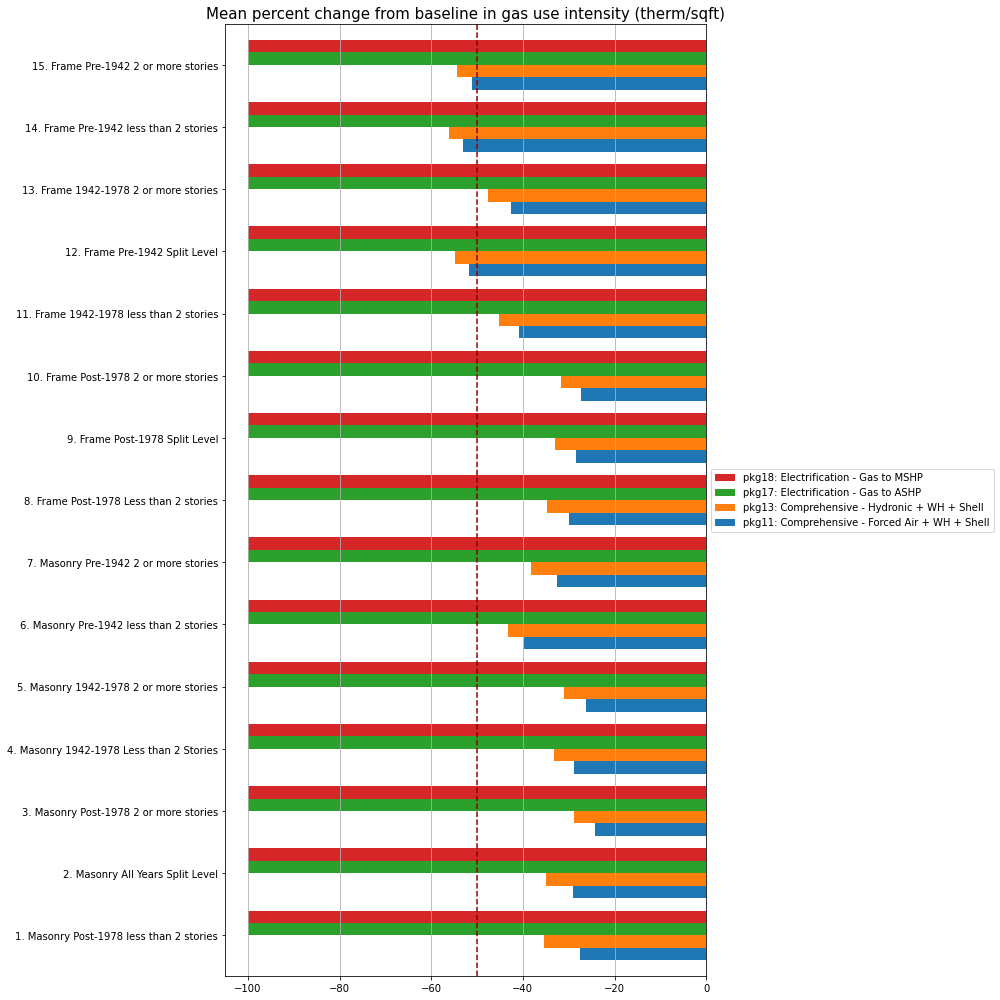

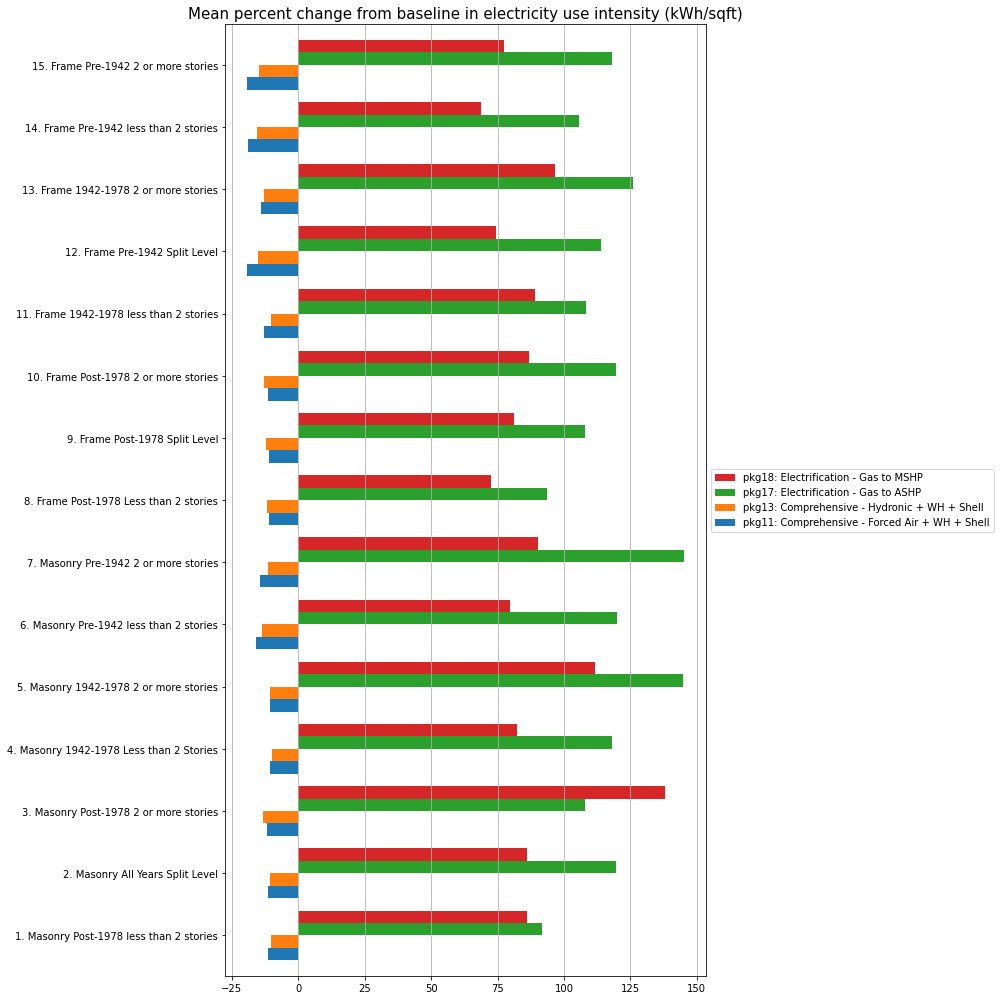

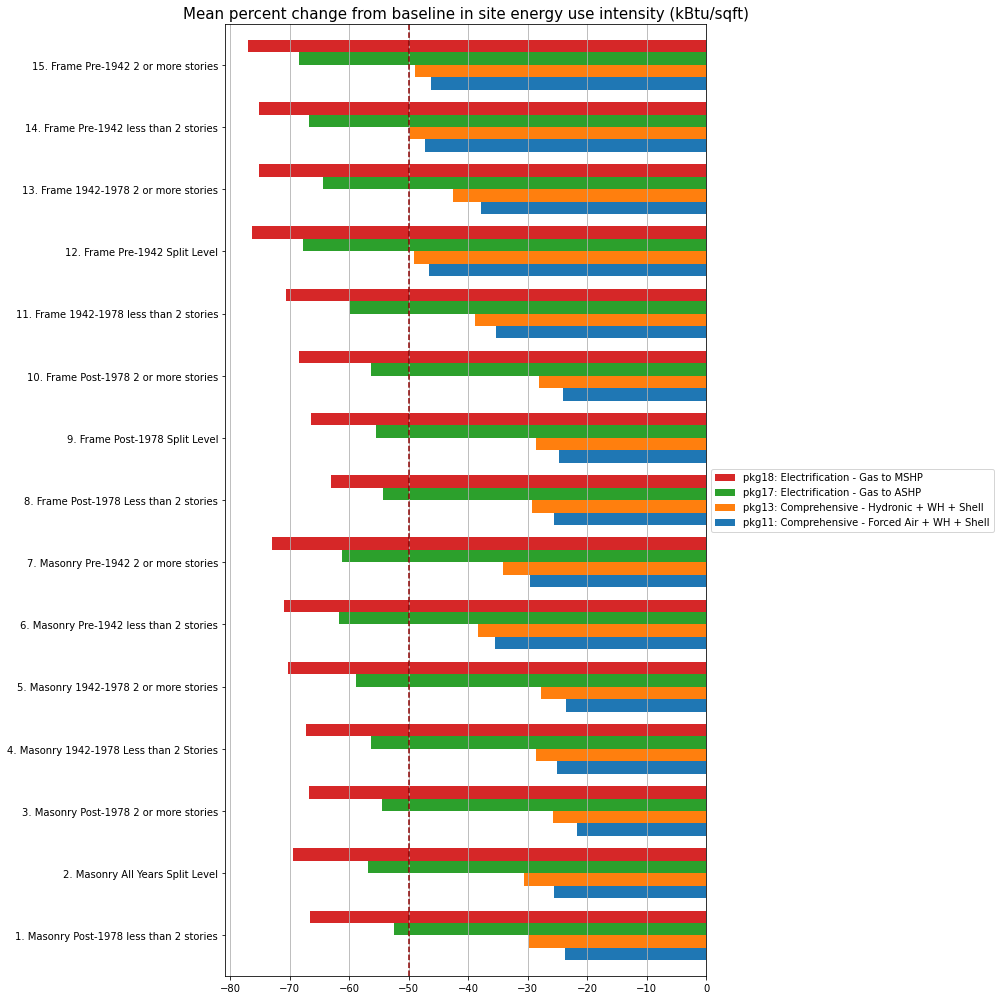

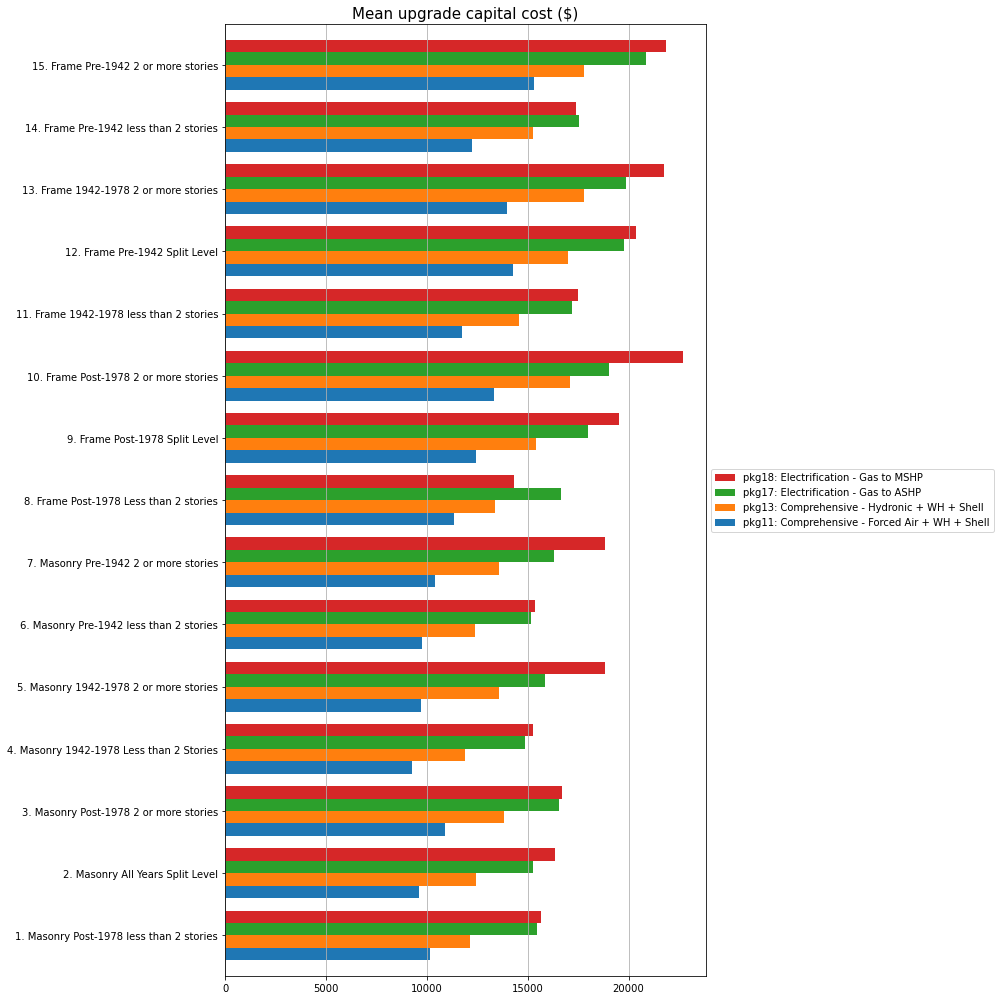

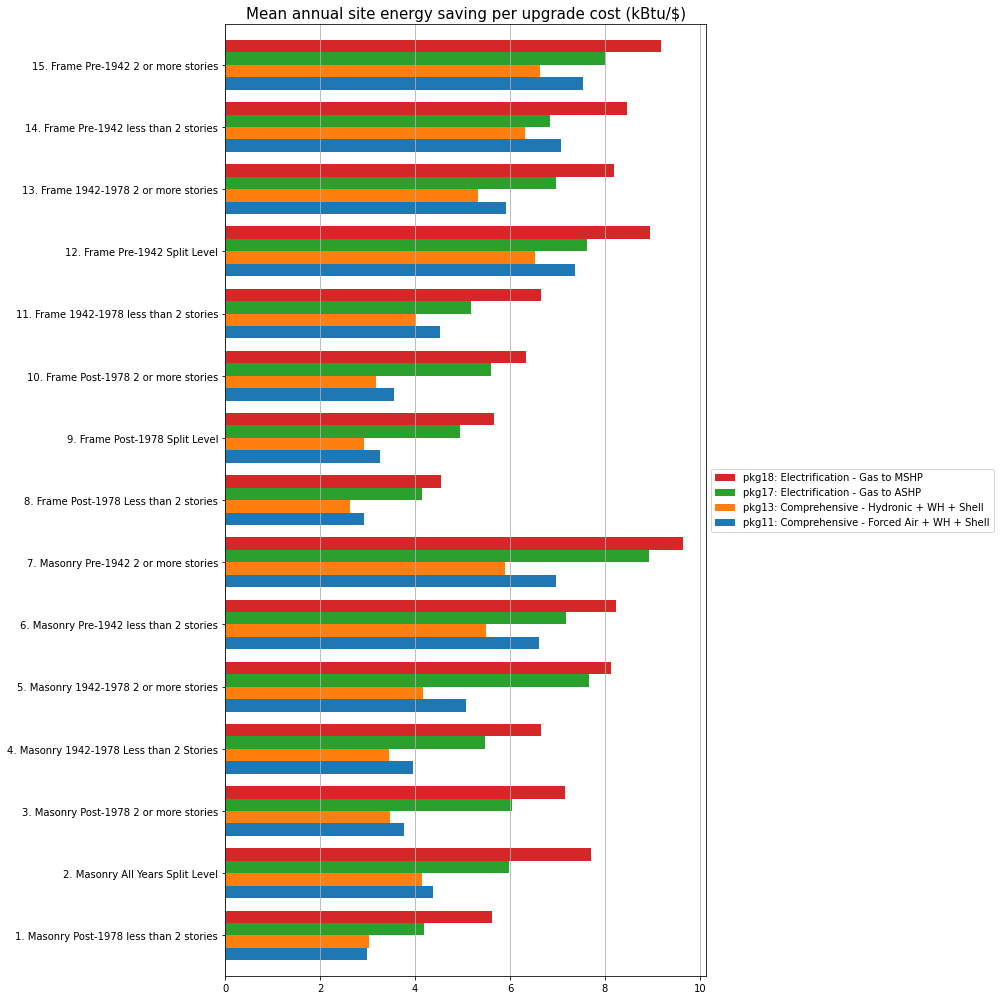

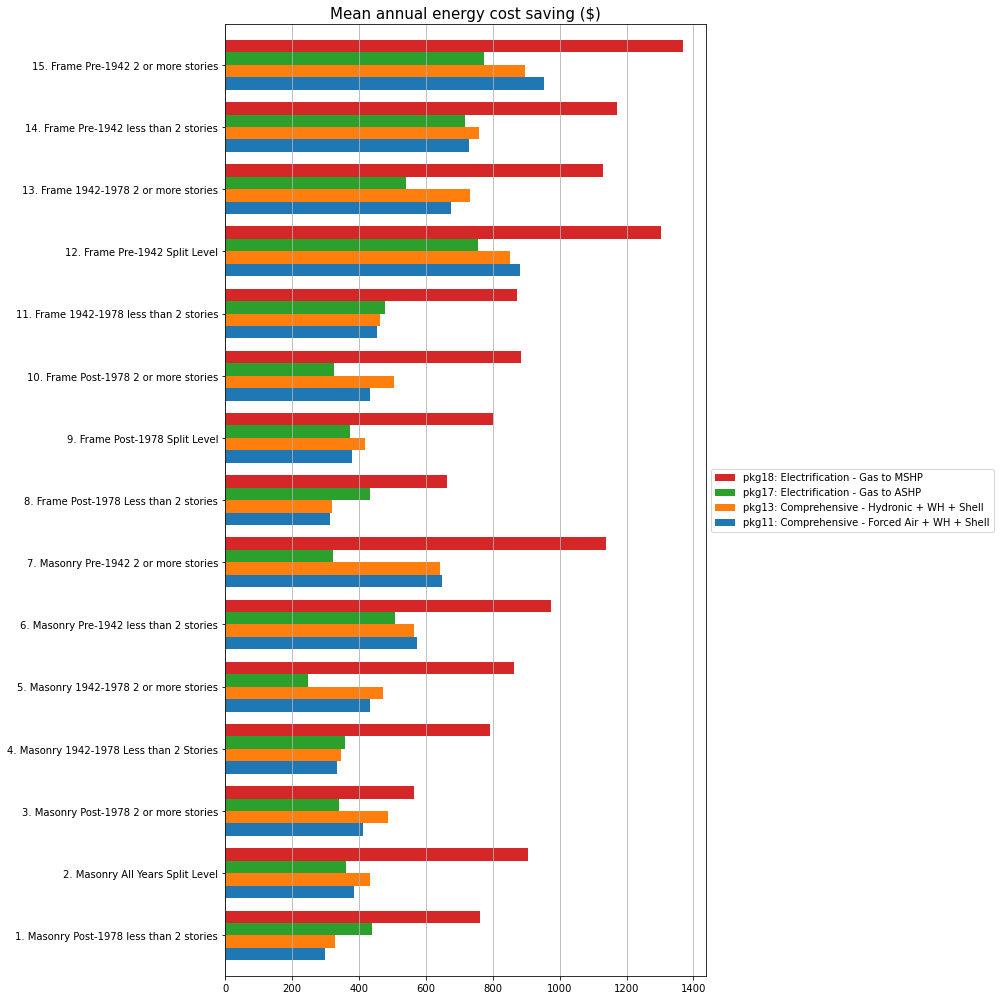

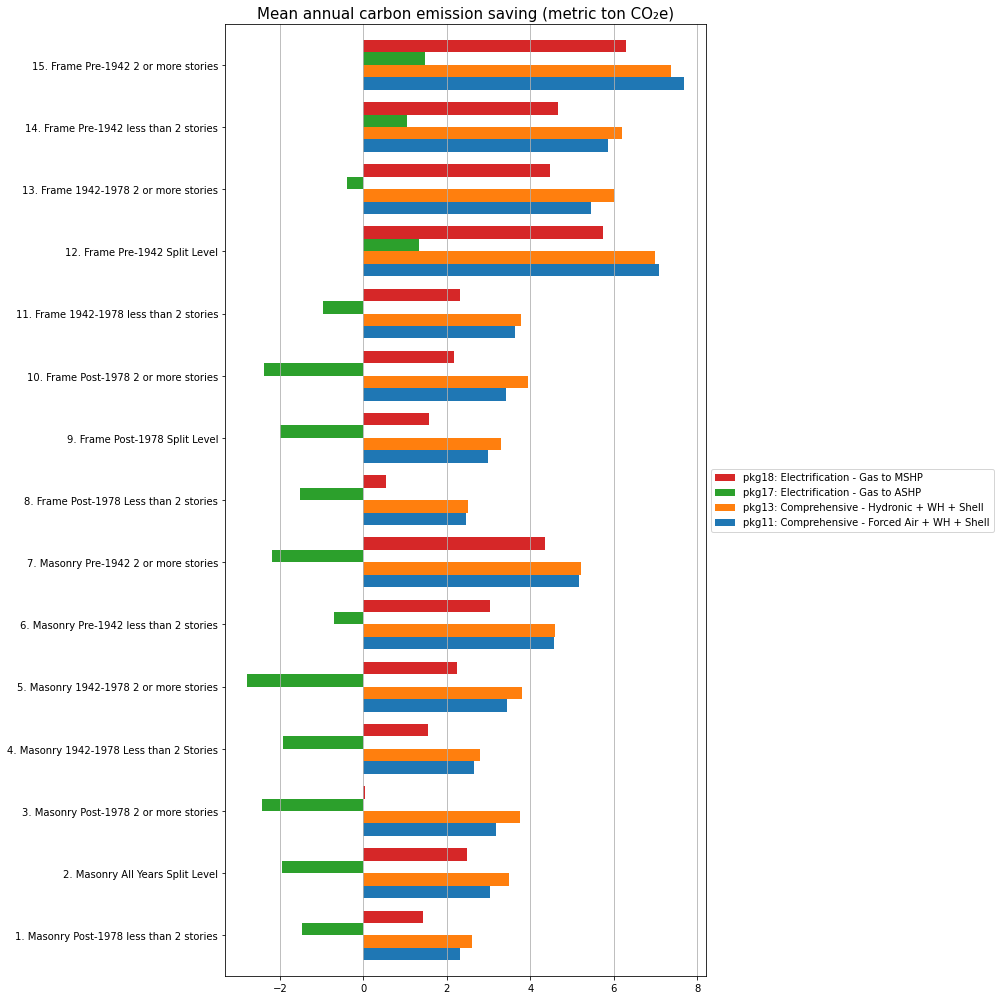

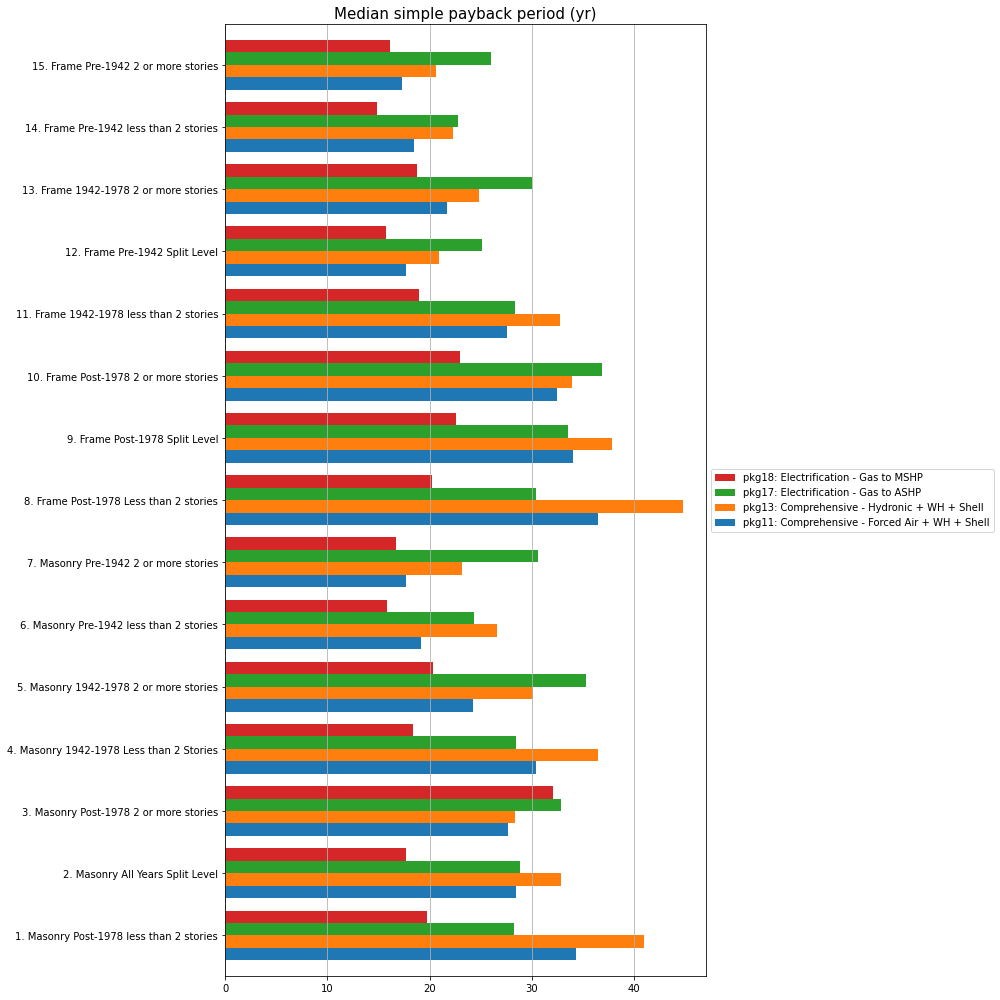

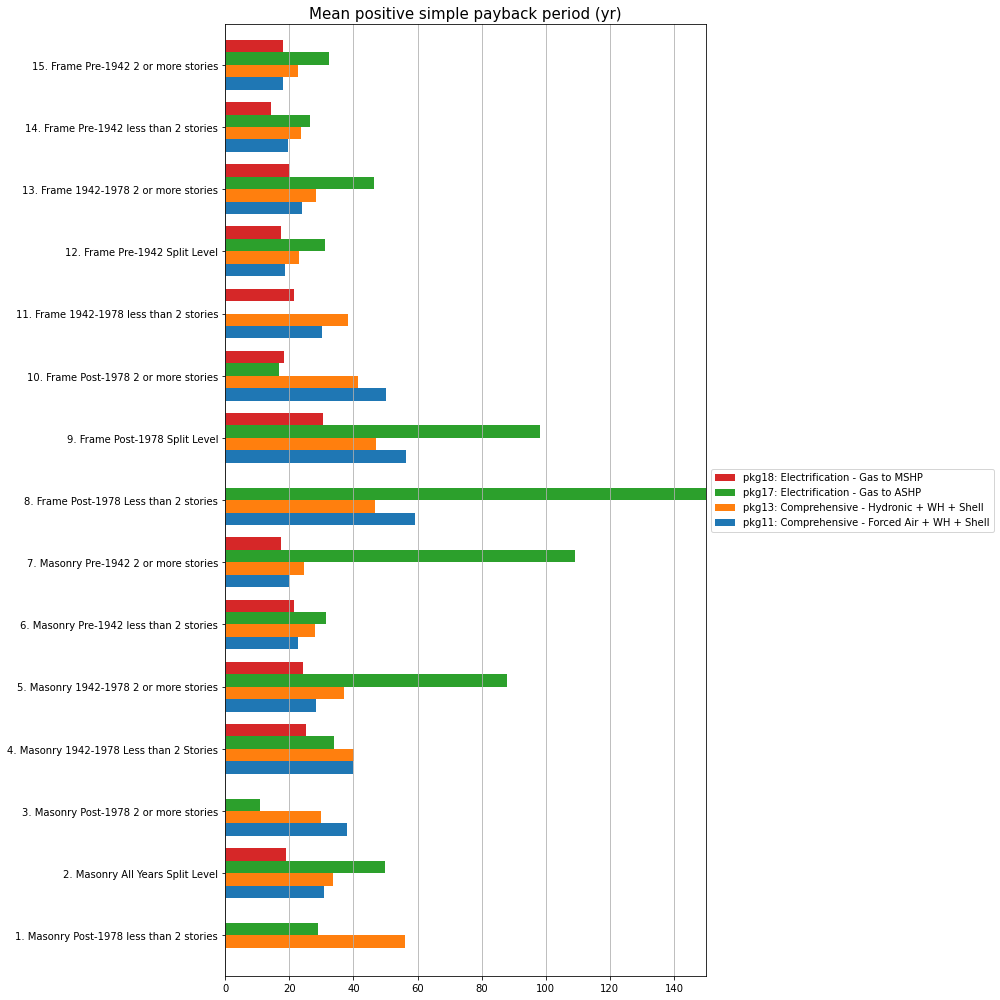

In [61]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
    'median_simple_payback': [-70, 70],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPi = groups2.set_index(idx)[para_to_plot]
    xmin = UPi.replace([np.inf, -np.inf], np.nan).min().min()
    xmax = UPi.replace([np.inf, -np.inf], np.nan).max().max()

    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(14, 14))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg21)
    # Group 1A: (upg01-upg10) N=10
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(para_label, fontsize=15, y=1)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot in ['median_simple_payback', 'mean_pos_simple_payback']:
        if xmax >= 150:
            ax.set_xlim(0,150)
    
    plt.tight_layout()
    
    filename = f'{iter_path}-comparison_{para_to_plot}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [62]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']].copy()
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
groups_avg

Natural gas rate multiplier: 1


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg
0,mean_ann_energy_cost_saving,11,Comprehensive - Forced Air + WH + Shell,674.740,452.750,433.350,313.800,379.850,953.020,879.960,729.230,433.330,333.290,384.130,410.550,298.610,647.070,573.480,550.583173
1,mean_ann_energy_cost_saving,13,Comprehensive - Hydronic + WH + Shell,733.320,461.930,503.370,319.580,419.210,896.870,852.680,757.630,470.440,346.440,433.480,486.090,327.490,641.200,565.750,552.931881
2,mean_ann_energy_cost_saving,17,Electrification - Gas to ASHP,541.240,478.100,325.630,431.750,373.120,773.870,755.420,717.360,246.510,358.840,361.170,341.560,438.160,321.910,507.010,463.756977
3,mean_ann_energy_cost_saving,18,Electrification - Gas to MSHP,1130.670,872.810,884.410,663.220,800.510,1369.370,1302.160,1170.120,864.880,792.830,906.780,563.420,762.490,1138.640,973.750,976.427667
4,mean_ann_kbtu_saved_per_dollar,11,Comprehensive - Forced Air + WH + Shell,5.920,4.530,3.550,2.930,3.270,7.530,7.380,7.070,5.080,3.960,4.370,3.770,2.980,6.960,6.610,5.213744
5,mean_ann_kbtu_saved_per_dollar,13,Comprehensive - Hydronic + WH + Shell,5.330,4.010,3.180,2.620,2.930,6.640,6.530,6.320,4.170,3.460,4.140,3.470,3.020,5.890,5.500,4.572913
6,mean_ann_kbtu_saved_per_dollar,17,Electrification - Gas to ASHP,6.980,5.180,5.610,4.140,4.950,8.000,7.620,6.840,7.660,5.470,5.970,6.040,4.180,8.920,7.180,6.512703
7,mean_ann_kbtu_saved_per_dollar,18,Electrification - Gas to MSHP,8.200,6.650,6.340,4.550,5.660,9.180,8.940,8.460,8.120,6.650,7.700,7.160,5.620,9.650,8.240,7.410030
8,mean_ann_metric_ton_co2e_saving,11,Comprehensive - Forced Air + WH + Shell,5.459,3.631,3.411,2.461,2.986,7.691,7.097,5.870,3.453,2.644,3.042,3.172,2.319,5.156,4.571,4.388708
9,mean_ann_metric_ton_co2e_saving,13,Comprehensive - Hydronic + WH + Shell,6.004,3.777,3.954,2.516,3.295,7.369,6.998,6.199,3.793,2.792,3.499,3.760,2.610,5.224,4.585,4.472372


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/plots/mean_values_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving...
    - Group1
Plotting Chicago avg: mean_ann_kbtu_saved_per_dollar...
    - Group1
Plotting Chicago avg: mean_ann_metric_ton_co2e_saving...
    - Group1
Plotting Chicago avg: mean_pct_delta_elec_eui...
    - Group1
Plotting Chicago avg: mean_pct_delta_gas_eui...
    - Group1
Plotting Chicago avg: mean_pct_delta_site_eui...
    - Group1
Plotting Chicago avg: mean_pos_simple_payback...
    - Group1
Plotting Chicago avg: mean_upgrade_cost...
    - Group1
Plotting Chicago avg: median_simple_payback...
    - Group1
Plotting Chicago avg: pct_pos_simple_payback...
    - Group1


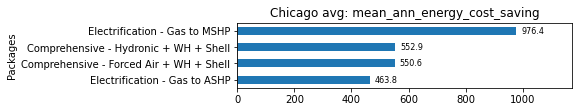

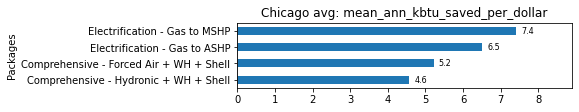

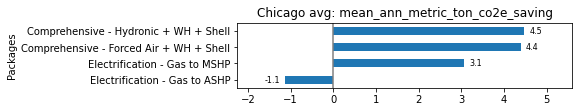

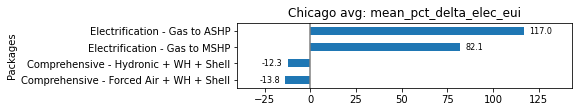

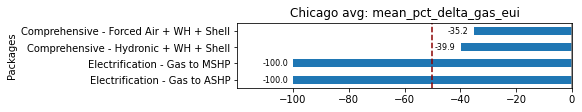

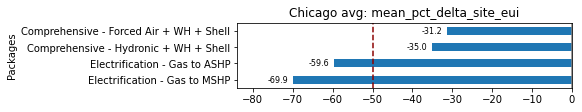

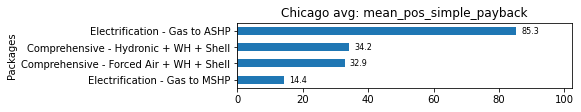

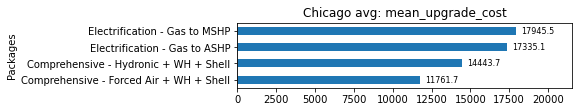

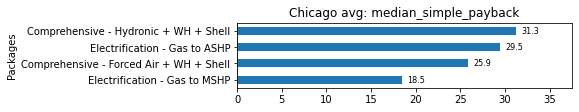

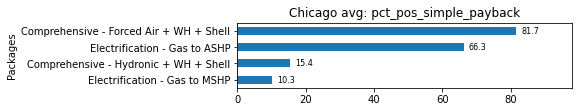

In [63]:
para_to_plot = 'Chicago avg' # <------

N_upgrades=19
upgrade_sets = {
    'Packages': range(6, N_upgrades+6),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.3. plot mean values for Chicago total stock 
Run cell below to load df for plots

In [64]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups_total = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'),
                         header=[0])
    
    print(f'"groups_total{fn_ext}" df loaded from file.')
    display(groups_total)
    

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/plots/sum_values_chicago_total

Plotting Chicago total ann_elec_cost_saving...
    - Group1
Plotting Chicago total ann_energy_cost_saving...
    - Group1
Plotting Chicago total ann_gas_cost_saving...
    - Group1
Plotting Chicago total ann_kwh_elec_saving...
    - Group1
Plotting Chicago total ann_mbtu_site_energy_saving...
    - Group1
Plotting Chicago total ann_metric_ton_co2e_saving...
    - Group1
Plotting Chicago total ann_therm_gas_saving...
    - Group1
Plotting Chicago total upgrade_cost...
    - Group1


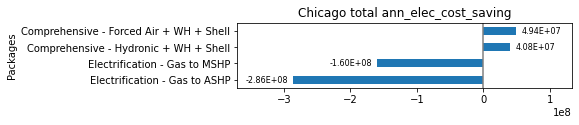

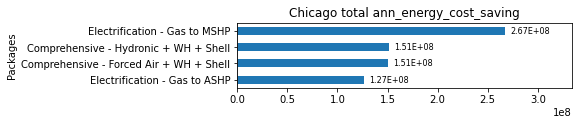

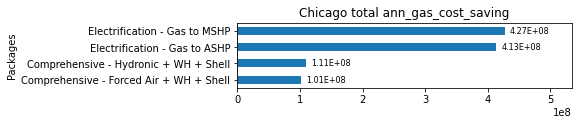

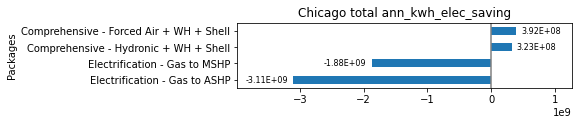

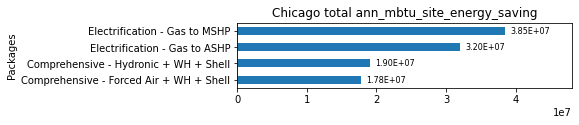

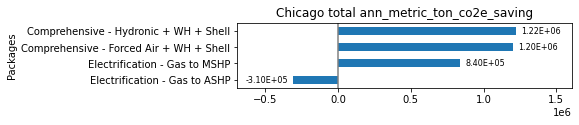

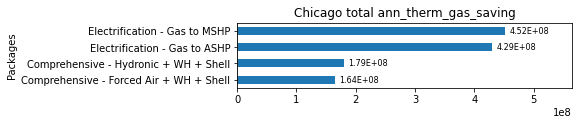

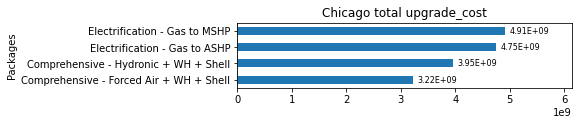

In [65]:
para_to_plot = 'Chicago total' # <------

N_upgrades = 4
upgrade_sets = {
    'Packages': [11, 13, 17, 18],
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path3 = os.path.join(plot_path, 'sum_values_chicago_total')
if not os.path.exists(plot_path3):
    os.mkdir(plot_path3)
print(f'plot dir: {plot_path3}\n')

if NG_rate_multiplier == 1:  
    metrics_to_plot = groups_total['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_gas_cost_saving']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot} {metric[5:]}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_total[(groups_total['metrics']==metric) & 
                              (groups_total['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.2E}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values.                      
                                            
        ax.margins(x=0.25)
        ax.axvline(x=0, linestyle='-', color='gray')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric[5:]}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path3, filename),
                    bbox_inches='tight')

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [58]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    all_proto_upgrades = pd.read_csv(os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['package_no'].unique().max()
    print(f'   total number of packages: {N_upgrades}')
    
    display(all_proto_upgrades)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_03/processed results/plots/distribution_by_prototype

>> 1. plotting pct_delta_gas_eui...
>> 2. plotting pct_delta_elec_eui...
>> 3. plotting pct_delta_site_eui...
>> 4. plotting upgrade_cost...
>> 5. plotting ann_kbtu_saved_per_dollar...
>> 6. plotting ann_energy_cost_saving...
>> 7. plotting ann_metric_ton_co2e_saving...
>> 8. plotting simple_payback...


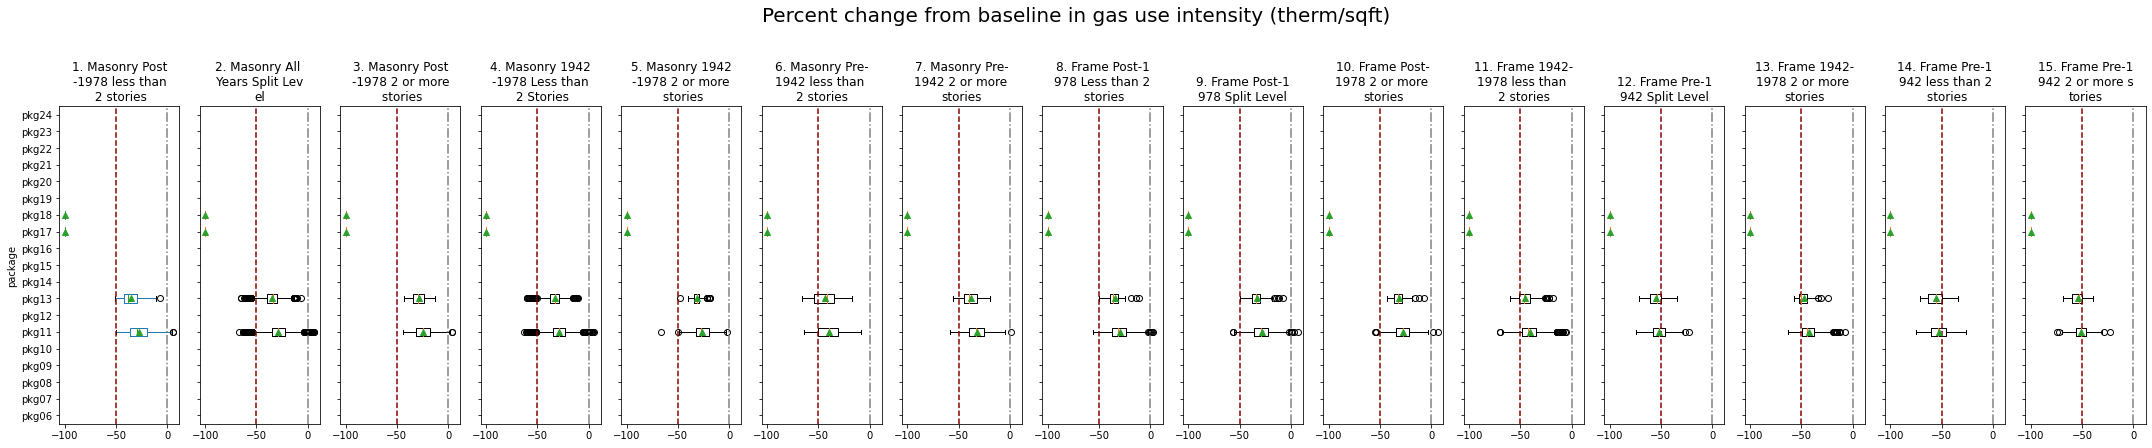

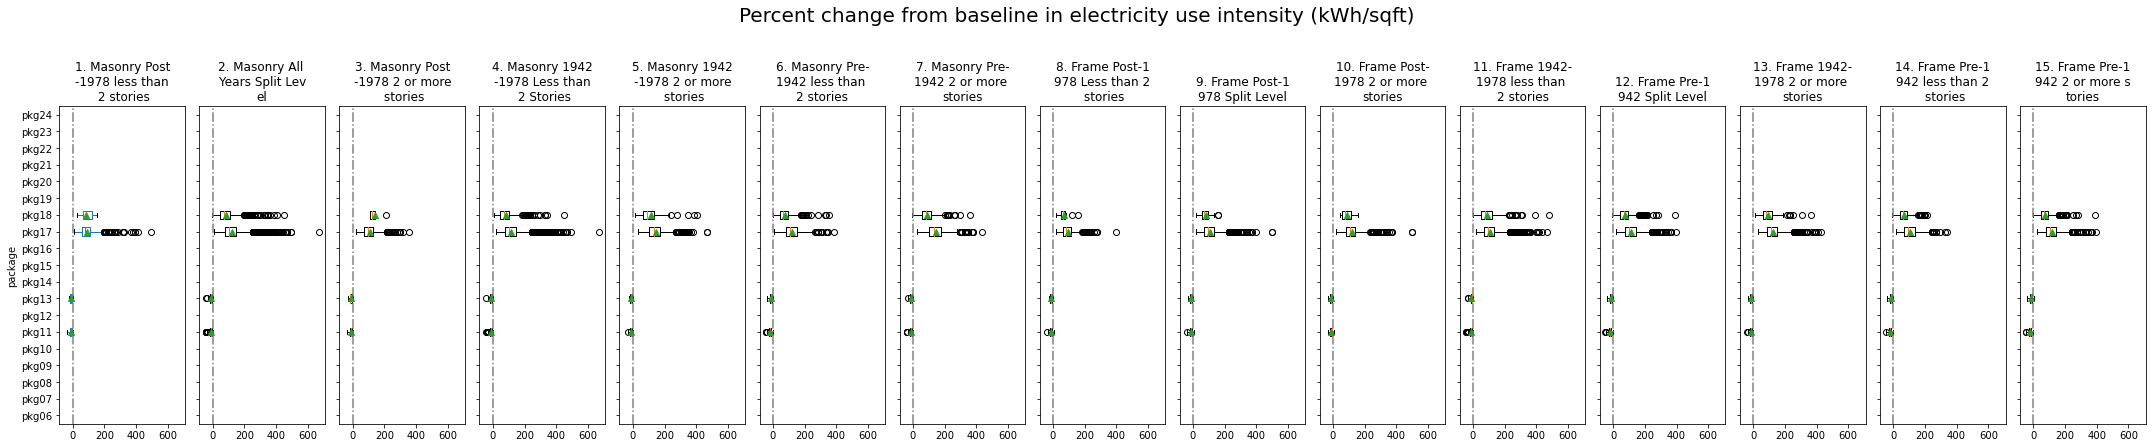

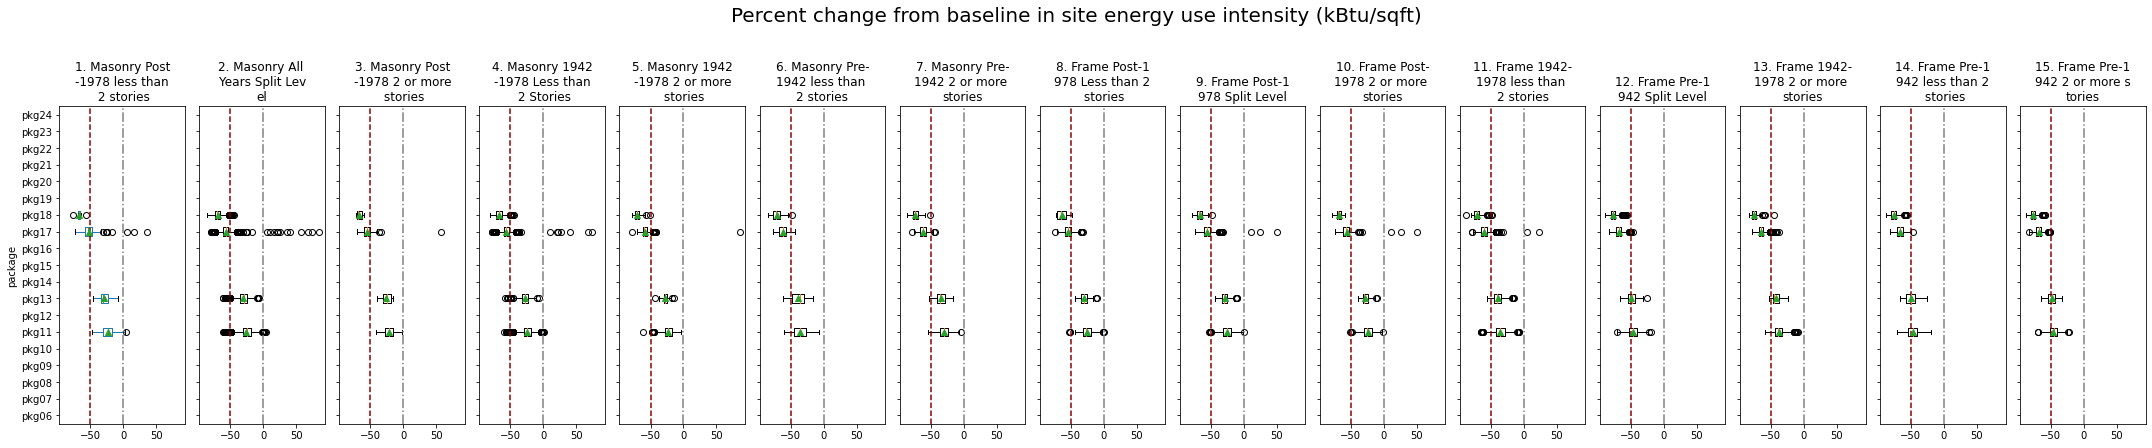

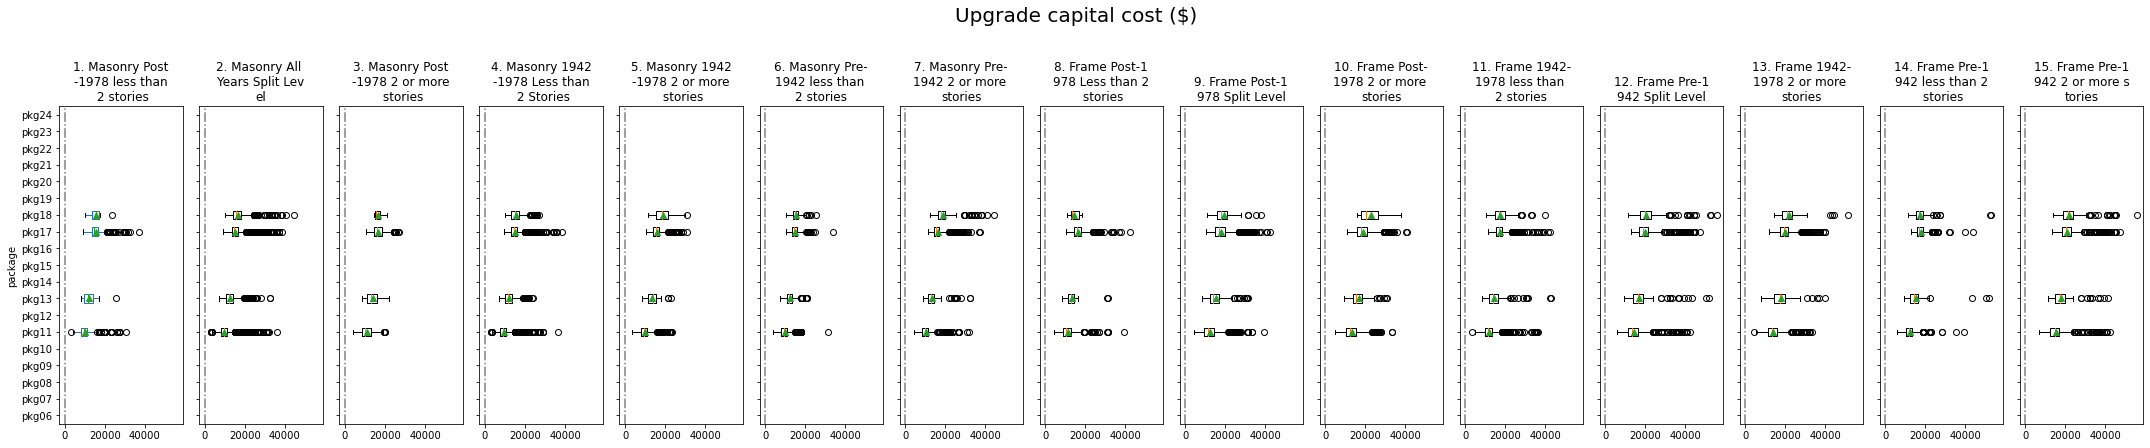

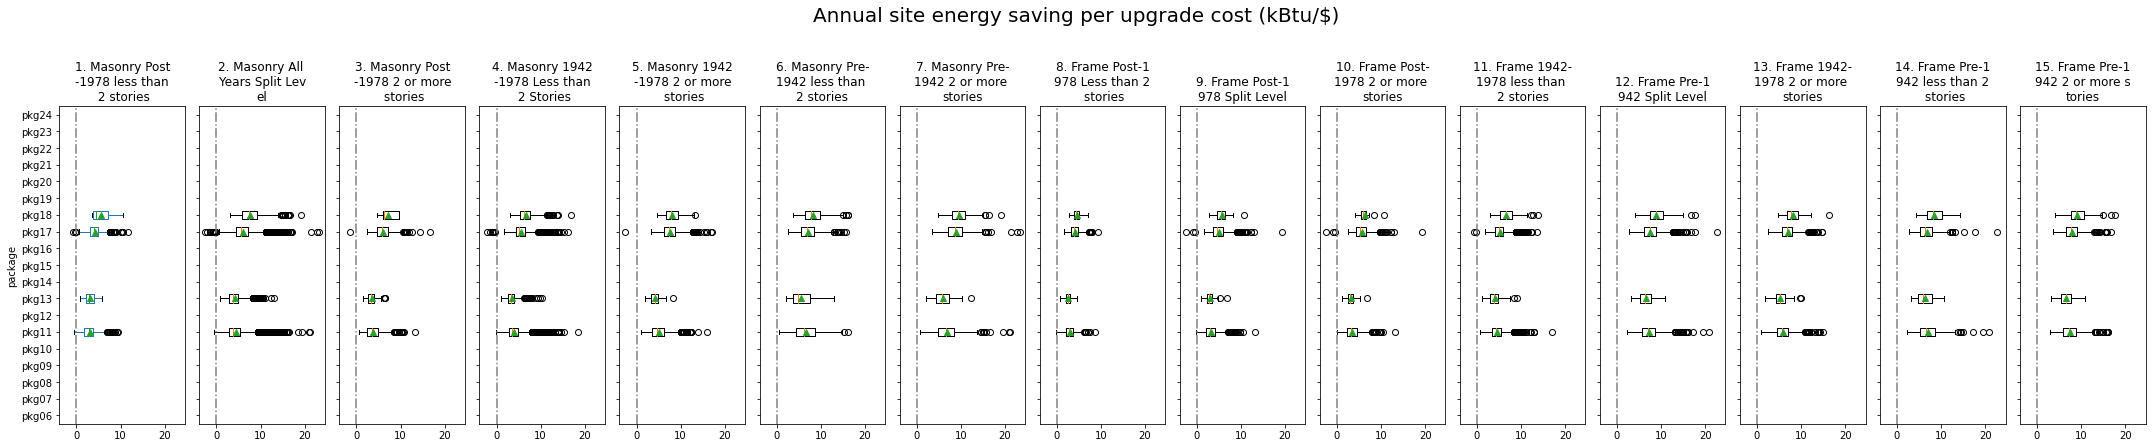

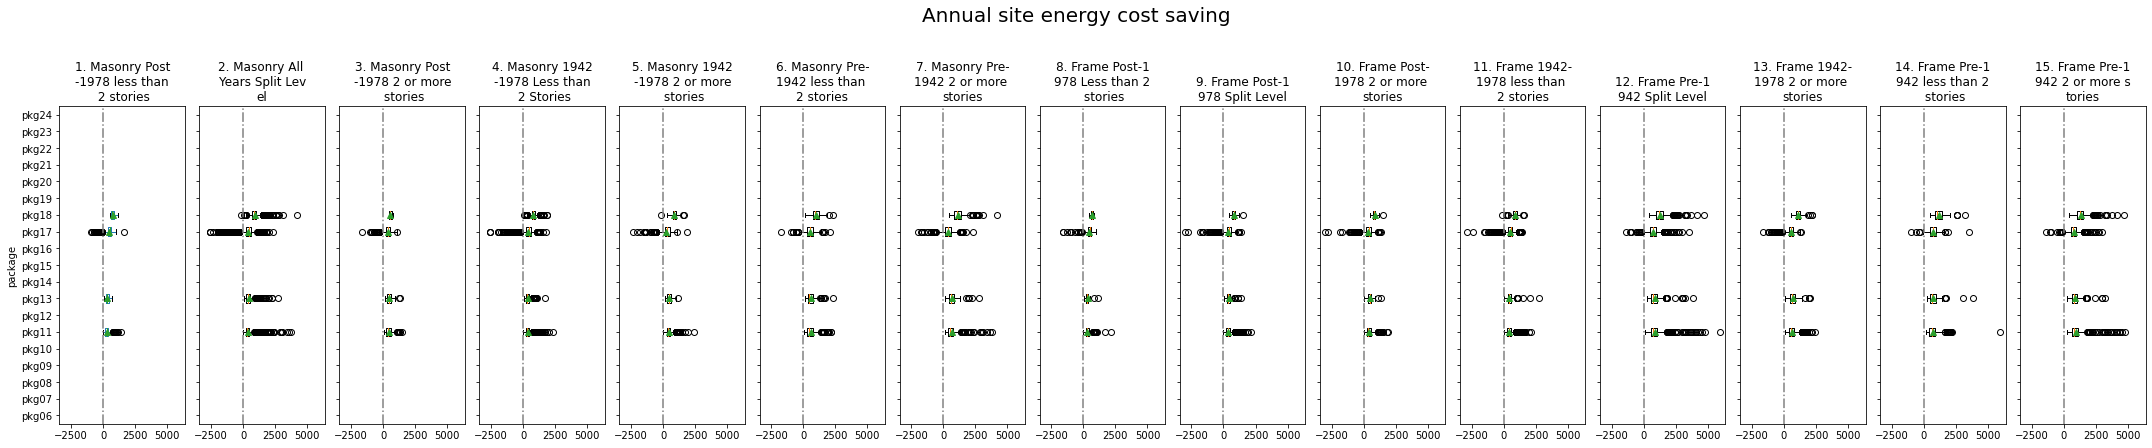

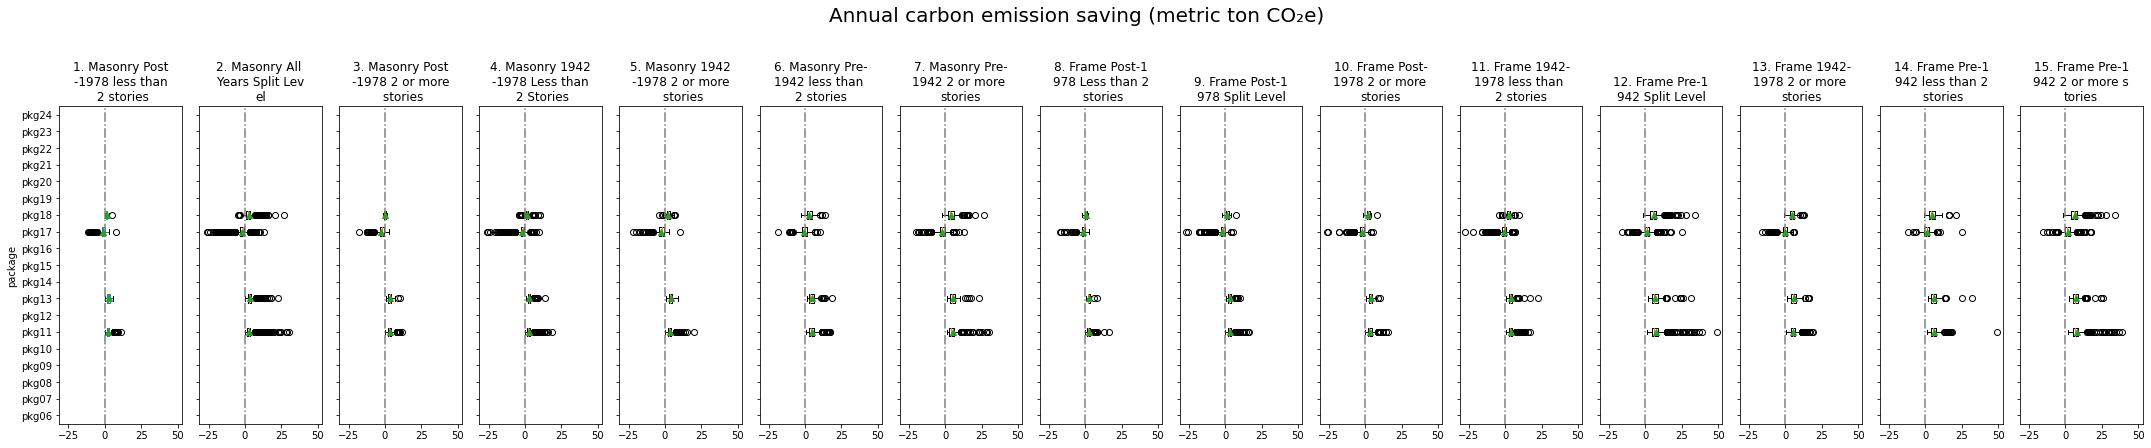

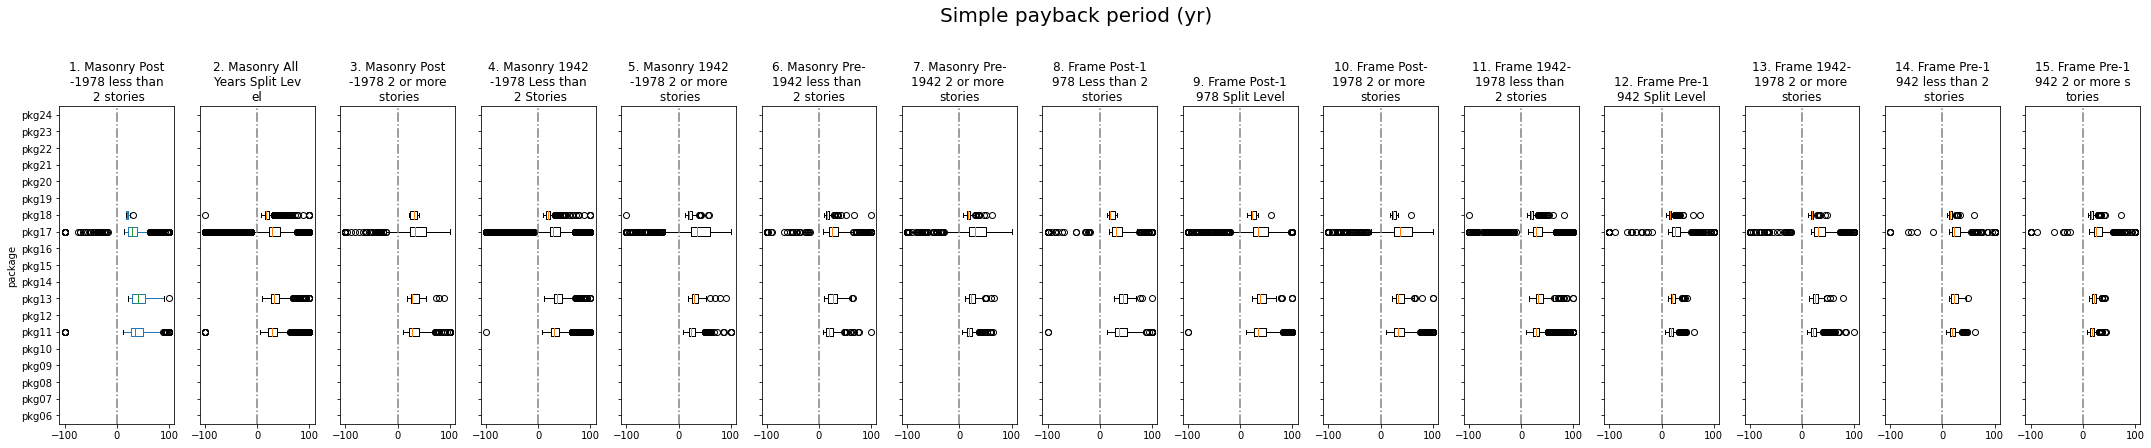

In [66]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

N_upgrades=19
cols_to_match = list(f'pkg{n:02d}' for n in range(6,N_upgrades+6))

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 6))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'package_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'package_no'] = 'pkg'+p['package_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='package_no')
        p = p.set_index([p.index, 'package_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')
        
        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1).reset_index(drop=True)
    
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('package')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
            
        ax.set_yticks(range(1, 1+N_upgrades))
        ax.set_yticklabels(cols_to_match)
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')
